In [1]:
import sympy as sp
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
from matplotlib import cm
from sympy import cos, sin, exp, Matrix, sqrt
from sympy.simplify.fu import TR10, TR9
import pandas as pd

from IPython.display import display, Math
from IPython.display import display as disp
from utils import symdisp, symplot
import ipywidgets as widgets
from ipywidgets import interact

from commpy.utilities import upsample

from optic.comm.modulation import modulateGray, demodulateGray, grayMapping
from optic.dsp.core import firFilter, pulseShape, lowPassFIR, pnorm, decimate
from optic.comm.metrics import signal_power
from optic.plot import eyediagram, pconst, plotDecisionBoundaries, randomCmap, plotColoredConst

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 2000)
pd.options.display.float_format = '{:,d}'.format

In [3]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
from IPython.display import display

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
figsize(8, 3)

# Transmissão Digital da Informação

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#O-modelo-de-canal-AWGN" data-toc-modified-id="O-modelo-de-canal-AWGN-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>O modelo de canal AWGN</a></span></li><li><span><a href="#Receptores-e-receptores-ótimos" data-toc-modified-id="Receptores-e-receptores-ótimos-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Receptores e receptores ótimos</a></span><ul class="toc-item"><li><span><a href="#Demodulador-por-correlação" data-toc-modified-id="Demodulador-por-correlação-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Demodulador por correlação</a></span></li><li><span><a href="#Demodulador-por-filtro-casado" data-toc-modified-id="Demodulador-por-filtro-casado-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Demodulador por filtro casado</a></span><ul class="toc-item"><li><span><a href="#Filtro-casado" data-toc-modified-id="Filtro-casado-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Filtro casado</a></span></li><li><span><a href="#Maximização-da-$\mathrm{SNR}$" data-toc-modified-id="Maximização-da-$\mathrm{SNR}$-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Maximização da $\mathrm{SNR}$</a></span></li></ul></li></ul></li><li><span><a href="#Detectores-ótimos" data-toc-modified-id="Detectores-ótimos-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Detectores ótimos</a></span><ul class="toc-item"><li><span><a href="#Critério-de-decisão-MAP" data-toc-modified-id="Critério-de-decisão-MAP-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Critério de decisão MAP</a></span></li><li><span><a href="#Critério-de-decisão-ML" data-toc-modified-id="Critério-de-decisão-ML-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Critério de decisão ML</a></span></li><li><span><a href="#Métricas-de-decisão" data-toc-modified-id="Métricas-de-decisão-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Métricas de decisão</a></span></li><li><span><a href="#Implementação-de-detectores-MAP-e-ML" data-toc-modified-id="Implementação-de-detectores-MAP-e-ML-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Implementação de detectores MAP e ML</a></span></li><li><span><a href="#Exemplo:-sinal-M-PAM-equiprovável" data-toc-modified-id="Exemplo:-sinal-M-PAM-equiprovável-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Exemplo: sinal M-PAM equiprovável</a></span></li><li><span><a href="#Exemplo:-sinal-M-PAM-não-equiprovável" data-toc-modified-id="Exemplo:-sinal-M-PAM-não-equiprovável-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Exemplo: sinal M-PAM não-equiprovável</a></span></li><li><span><a href="#Exemplo:-sinal-M-QAM-equiprovável" data-toc-modified-id="Exemplo:-sinal-M-QAM-equiprovável-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Exemplo: sinal M-QAM equiprovável</a></span></li><li><span><a href="#Exemplo:-sinal-M-QAM-não-equiprovável" data-toc-modified-id="Exemplo:-sinal-M-QAM-não-equiprovável-3.8"><span class="toc-item-num">3.8&nbsp;&nbsp;</span>Exemplo: sinal M-QAM não-equiprovável</a></span></li></ul></li><li><span><a href="#Cálculo-da-probabilidade-de-erro-para-modulações-sem-memória-em-canais-AWGN" data-toc-modified-id="Cálculo-da-probabilidade-de-erro-para-modulações-sem-memória-em-canais-AWGN-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Cálculo da probabilidade de erro para modulações sem memória em canais AWGN</a></span><ul class="toc-item"><li><span><a href="#Modulações-binárias-antipodais" data-toc-modified-id="Modulações-binárias-antipodais-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Modulações binárias antipodais</a></span></li><li><span><a href="#Modulações-binárias-ortogonais" data-toc-modified-id="Modulações-binárias-ortogonais-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Modulações binárias ortogonais</a></span></li><li><span><a href="#Modulações-M-PAM" data-toc-modified-id="Modulações-M-PAM-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Modulações M-PAM</a></span></li><li><span><a href="#Modulações-M-PSK" data-toc-modified-id="Modulações-M-PSK-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Modulações M-PSK</a></span></li><li><span><a href="#Modulações-M-QAM-&quot;quadradas&quot;-(square-M-QAM)" data-toc-modified-id="Modulações-M-QAM-&quot;quadradas&quot;-(square-M-QAM)-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Modulações M-QAM "quadradas" (<em>square M-QAM</em>)</a></span></li></ul></li><li><span><a href="#Limitante-da-união-de-probabilidades-de-erro" data-toc-modified-id="Limitante-da-união-de-probabilidades-de-erro-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Limitante da união de probabilidades de erro</a></span></li><li><span><a href="#Referências" data-toc-modified-id="Referências-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Referências</a></span></li></ul></div>

# Receptores ótimos para canais AWGN

<img src="./figuras/Fig1.png" width="900">
 <center>Fig.1: Diagrama de blocos de um sistema de transmissão digital genérico.</center>

##  O modelo de canal AWGN

Considere o modelo de canal em que os sinais transmitidos são afetados apenas por ruído branco gaussiano aditivo (*additive white Gaussian noise* - AWGN). Nesse modelo, o ruído é representado por um processo aleatório gaussiano, ou seja, para cada instante $t$ no tempo, o ruído $n(t)$ adicionado ao sinal é dado por uma variável aleatória gaussiana de média $\mu$ igual a zero e com uma certa variância $\sigma^2$. Desse modo, seja $s(t)$ o sinal enviado pelo transmissor ao canal, o modelo de canal AWGN assume que um ruído $n(t)$ será adicionado ao sinal de informação durante o processo de comunicação, como indicado na figura a seguir

<img src="./figuras/Fig3.png" width="600">
<center>Fig.2: Esquemático de um sistema de transmissão digital via canal AWGN.</center>

em que $r(t)$ representa o sinal ruidoso na entrada do receptor.

Assuma que em cada intervalo de sinalização $T_s$, o transmissor envia um sinal $s_m(t)$ dentre os $M$ possíveis do esquema de modulação utilizado, i.e. $\left\lbrace s_m(t), m = 1,2,\dots, M\right\rbrace$. Considere que no intervalo de $0\leq t \leq T_s$ o transmissor enviou a sinal $s_m(t)$. Uma vez que o canal adiciona ruído ao sinal transmitido, o sinal recebido $r(t)$ no intervalo $0\leq t \leq T_s$ pode ser expresso como

$$\begin{equation}\label{awgnch_eq1} r(t) = s_m(t) + n(t)\end{equation}$$

em que $n(t)$ é uma função amostra de um processo estocástico gaussiano com densidade espectral de potência $S_n(f)=\frac{N_0}{2}$.

## Receptores e receptores ótimos

Baseado na observação de $r(t)$ durante o intervalo de sinalização, o receptor tem a tarefa de inferir qual dos $M$ possíveis sinais foi enviado pelo transmissor. Uma vez que o canal adiciona uma perturbação aleatória ao sinal transmitido, o processo de inferência passa a ter caráter probabilístico. Nesse sentido, sempre existe a possibilidade de que o canal altere a forma do sinal $s_m(t)$ de modo que o sinal recebido possa se assemelhar a um outro sinal do conjunto  $\left\lbrace s_m(t), m = 1,2,\dots, M\right\rbrace$ diferente do que foi transmitido. Logo, se o receptor assume que o sinal transmitido é aquele que tem maior proximidade com o sinal recebido, a presença de ruído pode levar a erros no processo de deteção da informação transmitida. O projeto de receptores ótimos, então, baseia-se no estabelecimento de esquemas de recepção que minimizem a probabilidade da ocorrência de erros no processo de decisão da informação transmitida atrabés do canal.

Como ilustrado na figura abaixo, a tarefa do receptor pode ser subdividida em duas partes:

* **Demodulação**: conversão do sinal recebido $r(t)$ em um vetor de amostras discretas $\mathbf{r} = [r_1,r_2,\dots, r_N]$, em que $N$ é a dimensão dos sinais transmitidos.

* **Detecção**: a partir de $\mathbf{r}$, decidir qual dos $M$ possíveis sinais foram transmitidos.

<img src="./figuras/Fig5.png" width="700">
<center>Fig.3: Estrutura de blocos de um receptor digital.</center>

Para entendermos a tarefa do demodulador, precisamos recorrer ao conceito de espaço de sinais. Considere que os sinais $s_m(t)$ gerados pelo transmissor possam ser expandidos a partir de uma base de $N$ funções ortonormais $f_n(t)$, isto é

$$\begin{equation} s_m(t) = \sum_{k=1}^{N}s_{mk}f_k(t) \end{equation}$$

em que o vetor $\mathbf{s}_m = [s_1, s_2, \dots, s_N]$ corresponde à representação de $s_m(t)$ na base ortonormal $\left\lbrace f_n(t) \right\rbrace_{n=1}^{N}$. Por base ortonormal, entende-se que o produto interno entre duas funções $f_i(t)$ e $f_j(t)$ quaisquer da base obedece a seguinte propriedade

$$\begin{equation} 
\langle f_i(t), f_j(t) \rangle = \int_{-\infty}^{\infty}f_i(t)f_j^*(t) dt = \begin{cases} 1, & \text{ se } i=j\\ 0, & \text{ se } i\neq j \end{cases} \end{equation} $$

em que $^*$ indica o conjugado complexo.

Assim, podemos decompor o sinal $s_m(t)$ em suas componentes vetoriais $s_1, s_2, \dots, s_N$ na base $\left\lbrace f_n(t) \right\rbrace_{n=1}^{N}$ realizando o produto interno entre $s_m(t)$ e cada elemento da base no intervalo 
$0\leq t \leq T_s$:

$$\begin{equation} 
\langle s_m(t), f_i(t) \rangle = \int_{0}^{T}s_m(t)f_i^*(t) dt = s_i \end{equation} $$

em que $s_i$ é o componente vetorial de $s_m(t)$ na direção de $f_i(t)$.

### Demodulador por correlação

Na Fig.4 a estrutura de um demodulador por correlação está ilustrada. No receptor, o sinal recebido é correlacionado com cada uma das $N$ funções que compõem a base ortonormal $\left\lbrace f_k(t) \right\rbrace_{k=1}^{N}$, ou seja, a saída de cada correlator corresponde à operação

$$\begin{align} 
\langle r(t), f_k(t) \rangle =& \int_{0}^{T}r(t)f_k(t) dt \\
=& \int_{0}^{T}[s_m(t) + n(t)]f_k(t) dt \\
=& \int_{0}^{T}s_m(t)f_k(t)dt + \int_{0}^{T}n(t)f_k(t) dt\\
=& s_{mk} + n_k = r_k
\end{align} $$

com $k=1, 2,\dots, M$.

<img src="./figuras/Fig6.png" width="500">
<center>Fig.4: Demodulador por correlação.</center>

A partir das projeções de $s(t)$ e $n(t)$ em cada uma das funções da base ortonormal, podemos escrever

$$\begin{align} r(t) & =\sum_{k=1}^N s_{m k} f_k(t)+\sum_{k=1}^N n_k f_k(t)+n^{\prime}(t) \\ & =\sum_{k=1}^N r_k f_k(t)+n^{\prime}(t)\end{align}$$

em que $n^{\prime}(t)=n(t)-\sum_{k=1}^N n_k f_k(t)$ corresponde aos componentes de $n(t)$ que são ortogonais à base ortonormal utilizada na transmissão. Uma vez que $n(t)$ é uma função amostra de um processo aleatório gaussiano, esta pode conter componentes $n^{\prime}(t)$ que não estão no espaço expandido pela base ortonormal, ou seja, que são ortogonais à cada um dos vetores da base.

Utilizando as propriedades da média e da autocorrelação do processo estocástico gaussiano estacionário associado ao ruído, temos que:

$$\begin{equation}
E\left[n_k\right]=\int_0^{T_s} E[n(t)] f_k(t) dt=0
\end{equation}$$

e 

$$
\begin{align}
E\left[n_k n_m\right] & = E\left[ \int_0^{T_s} n(t) f_k(t) dt \int_0^{T_s} n(\tau) f_m(\tau) d\tau\right] \\
& = \int_0^{T_s} \int_0^{T_s} E[n(t) n(\tau)] f_k(t) f_m(\tau) d t d \tau \\
& =\frac{N_0}{2}  \int_0^{T_s} \int_0^{T_s} \delta(t-\tau) f_k(t) f_m(\tau) d t d \tau \\
& = \frac{N_0}{2} \int_0^{T_s} f_k(t) \left[\int_0^{T_s} \delta(t-\tau)  f_m(\tau) d \tau \right] d t \\
& =\frac{N_0}{2} \int_0^{T_s} f_k(t) f_m(t) d t \\
& =\frac{N_0}{2} \delta_{m k}
\end{align}
$$

Desse modo, os termos $n_k$ são variáveis aleatórias gaussianas independentes e identicamente distribuídas (i.i.d), com média nula e variância $\sigma_n^2 = E[n_k^2] = \frac{N_0}{2}$.

Assumindo que o sinal $s_m(t)$ seja conhecido, podemos descrever os sinais $r_k$ na saída dos correlatores como variáveis aleatórias gaussianas independentes de média:

$$
\begin{equation}
E\left[r_k\right]=E\left[s_{m k}+n_k\right]=s_{m k} 
\end{equation}
$$
e variância
$$
\begin{align}
\sigma_r^2 &= E\left[r_k^2\right] - E[r_k]^2 \\
&= E\left[s_{mk}^2 + 2s_{mk}n_k + n_k^2\right] - s_{mk}^2\\
&= s_{mk}^2 + E[n_k^2] - s_{mk}^2\\
&= \sigma_n^2=\frac{N_0}{2}.
\end{align}
$$

Portanto, o vetor $\mathbf{r}$ pode ser representado pela seguinte função densidade de probabilidade condicional conjunta

$$ \begin{equation}\label{pdf_conj_1}
p\left(\mathbf{r}|\mathbf{s}_m\right)=\prod_{k=1}^N p\left(r_k|s_{m k}\right), \quad m=1,2, \ldots, M
\end{equation} $$

em que cada componente vetorial possui distribuição condicional

$$\begin{equation}\label{pdf_conj_2}
p\left(r_k|s_{m k}\right)=\frac{1}{\sqrt{\pi N_0}} \exp \left[-\frac{\left(r_k-s_{mk}\right)^2}{N_0}\right], \quad k=1,2, \ldots, N.
\end{equation}$$

Substituindo ($\ref{pdf_conj_2}$) in ($\ref{pdf_conj_1}$), temos:

$$\begin{equation}\label{pdf_conj_3}
p\left(\mathbf{r}|\mathbf{s}_m\right)=\frac{1}{\left(\pi N_0\right)^{N/2}} \exp \left[-\sum_{k=1}^N \frac{\left(r_k-s_{m k}\right)^2}{N_0}\right], \quad m=1,2, \ldots, M
\end{equation}$$

Por fim, faz-se necessário demonstrar que $n^{\prime}(t)$ é irrelevante no processo de decisão sobre qual dos $M$ possíveis sinais foi enviado pelo transmissor. Para tanto, basta mostrar que $n^{\prime}(t)$ e as saídas dos correlatores $r_1, r_2, \dots, r_N$ são independentes. Uma vez que tanto $n^{\prime}(t)$ quanto $r_1, r_2, \dots, r_N$ tem estatística gaussiana, basta mostrar que estes são descorrelacionados. Desse, modo, temos:

$$\begin{aligned} 
E\left[n^{\prime}(t) r_k\right] &= E\left[n^{\prime}(t)\right] s_{m k}+E\left[n^{\prime}(t) n_k\right] \\
&=E\left[n^{\prime}(t) n_k\right] \\ 
&=E\left\{\left[n(t)-\sum_{j=1}^N n_j f_j(t)\right] n_k\right\} \\ 
&=E\left\{\left[n(t)n_k-\sum_{j=1}^N n_j n_k f_j(t)\right] \right\} \\ 
&=E\left\{\left[n(t)\int_0^T n(\tau) f_k(\tau) d\tau -\sum_{j=1}^N n_j n_k f_j(t)\right]  \right\} \\
&=\int_0^T E[n(t) n(\tau)] f_k(\tau) d \tau-\sum_{j=1}^N E\left[n_j n_k\right] f_j(t) \\ 
&=\frac{N_0}{2} f_k(t)-\frac{N_0}{2} f_k(t)=0
\end{aligned}$$

Logo, conclui-se que $n^{\prime}(t)$ e $r_1, r_2, \dots, r_N$ são estatisticamente independentes, sendo as saídas dos correlatores uma *estatística suficiente* para o detector decidir qual sinal foi enviado pelo transmissor. 

### Demodulador por filtro casado

Uma maneira alternativa e equivalente para a construção do demodulador pode ser obtida a partir de um banco de $N$ filtros lineares, como ilustrado na Fig.5. Assuma que a resposta ao impulso $h_k(t)$ de cada um dos $N$ filtros que compõem o banco seja dada por

$$ 
\begin{equation}
h_k(t)=f_k(T_s-t), \quad 0 \leqslant t \leqslant T_s
\end{equation}
$$

em que $\left\lbrace f_k(t) \right\rbrace_{k=1}^{N}$ são as $N$ funções da base orthonormal e que $h_k(t)=0$ fora do intervalo $0 \leqslant t \leqslant T_s$.

<img src="./figuras/Fig7.png" width="500">
<center>Fig.5: Demodulador por filtro casado.</center>

Seja $y_k(t)$ a saída do $k$-ésimo filtro, temos que

$$ \begin{align} 
y_k(t) & =\int_0^t r(\tau) h_k(t-\tau) d \tau \\ 
& =\int_0^t r(\tau) f_k(T_s-t+\tau) d \tau, \quad k=1,2, \ldots, N.
\end{align}$$

Se amostrarmos $y_k(t)$ no instante $t=T_s$, temos

$$\begin{equation}
y_k(T_s)=\int_0^t r(\tau) f_k(\tau) d t=r_k, \quad k=1,2, \ldots, N
\end{equation}$$

Desse modo, a saída dos filtros amostrada em $t=T_s$ provê a mesma sequência de valores $r_1, r_2, \dots, r_N$ obtida na saída do banco de correlatores.

#### Filtro casado
Um filtro cuja resposta ao impulso é dada por $h(t) = s(T_s - t)$, em que $s(t)$ está confinada ao intervalo $0\leq t \leq T_s$, é denominado **filtro casado** ao sinal $s(t)$.

$$
\begin{equation}
y(t)=\int_0^t s(\tau) s(T_s-t+\tau) d \tau
\end{equation}
$$

#### Maximização da $\mathrm{SNR}$

Uma importante característica de um filtro casado é que, caso o sinal $s(t)$ estiver corrompido por ruído AWGN, o filtro cuja resposta ao impulso maximiza a $\mathrm{SNR}$ do sinal após a filtragem é o filtro casado associado a $s(t)$. Para demonstrar essa propriedade, considere que o sinal $r(t) = s(t) + n(t)$ na saída do canal AWGN passa por um filtro de resposta ao impulso $h(t)$. A saída $y(t)$ do filtro será dada por

$$
\begin{align}
y(t) & =\int_0^t r(\tau) h(t-\tau) d \tau \\
& =\int_0^t s(\tau) h(t-\tau) d \tau+\int_0^t n(\tau) h(t-\tau) d \tau.
\end{align}
$$

Amostrando a saída do filtro em $t=T_s$, temos

$$
\begin{align}
y(T_s) & = \int_0^{T_s} s(\tau)h(T_s-\tau)d\tau + \int_0^{T_s}n(\tau)h(T_s-\tau)d\tau\\
& = y_s(T_s)+y_n(T_s).
\end{align}
$$

Desse modo, podemos definir a $\mathrm{SNR}$ do sinal na saída do filtro como
$$
\begin{equation}\label{SNR_o}
\mathrm{SNR} = \frac{y_s^2(T_s)}{E\left[y_n^2(T_s)\right]},
\end{equation}
$$

em que o denominador $E\left[y_n^2(T_s)\right]$ corresponde à variância do ruído na saída do filtro, que podemos reescrever como:

$$
\begin{align}
E\left[y_n^2(T_s)\right] & =\int_0^{T_s} \int_0^{T_s} E[n(\tau) n(t)] h(T_s-\tau) h(T_s-t) d t d \tau \\
& =\frac{N_0}{2} \int_0^{T_s} \int_0^{T_s} \delta(t-\tau) h(T_s-\tau) h(T_s-t) d t d \tau \\
& =\frac{N_0}{2} \int_0^{T_s} h^2(T_s-t) d t.
\end{align}
$$

Logo, temos a seguinte expressão para a $\mathrm{SNR}$ na saída do filtro:
$$
\begin{equation}
\mathrm{SNR} =\frac{\left[\int_0^{T_s} s(\tau) h(T_s-\tau) d \tau\right]^2}{\frac{N_0}{2} \int_0^{T_s} h^2(T_s-t) d t}=\frac{\left[\int_0^{T_s} h(\tau) s(T_s-\tau) d \tau\right]^2}{\frac{N_0}{2} \int_0^{T_s} h^2(T_s-t) d t}.
\end{equation}
$$

Perceba que o termo  $\int_0^{T_s} h^2(T_s-t) d t$ no denominador corresponde à energia de $h(t)$, que pode ser mantida constante. Mantendo-se o denominador constante, a $\mathrm{SNR}$ será máxima se termo $\left[\int_0^{T_s} h(\tau) s(T_s-\tau) d \tau\right]^2$ do numerador for maximizado. Para tanto, considere o resultado da desigualdade de Cauchy-Schwarz que estabelece que para dois sinais $g_1(t)$ e $g_2(t)$ de energia finita 

$$
\begin{equation}
\left[\int_{-\infty}^{\infty} g_1(t) g_2(t) d t\right]^2 \leqslant \int_{-\infty}^{\infty} g_1^2(t) d t \int_{-\infty}^{\infty} g_2^2(t) d t
\end{equation}
$$

com igualdade se, e somente se, $g_1(t) = Cg_2(t)$, sendo $C$ uma constante arbitrária. Logo, a $\mathrm{SNR}$ será máxima quando $h(\tau) = Cs(T_s - \tau)$, ou seja, quando a resposta ao impulso $h(t)$ for casada ao sinal $s(t)$. Neste caso, tem-se que

$$
\begin{align}
\mathrm{SNR} & = \frac{\int_0^{T_s} C^2s^2(T_s-\tau) d \tau \int_0^{T_s}s^2(T_s-\tau) d \tau}{\frac{N_0}{2} \int_0^{T_s} C^2s^2(T_s-t) d t} \\
& =\frac{2}{N_0} \int_0^{T_s} s^2(T_s-\tau) d \tau \\
& =\frac{2}{N_0} \int_0^{T_s} s^2(t) d t \\
& = \frac{2E}{N_0}
\end{align}
$$

em que $E = \int_0^{T_s} s^2(t) d t$ é a energia do sinal $s(t)$. Portanto, a $\mathrm{SNR}$ depende apenas da energia do sinal $s(t)$ e não de qualquer outra característica do mesmo.

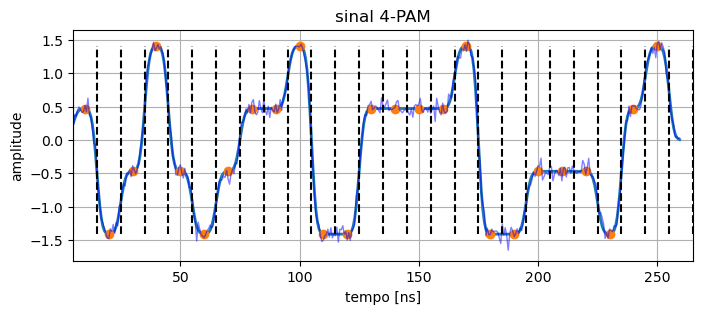

In [6]:
M = 4

# parâmetros da simulação
SpS = 16            # Amostras por símbolo
Rs  = 100e6         # Taxa de símbolos
Ts  = 1/Rs          # Período de símbolo em segundos
Fa  = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta  = 1/Fa          # Período de amostragem

# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size = int(25*np.log2(M)))

# generate ook modulated symbol sequence
symbTx = modulateGray(bitsTx, M, 'pam')    
symbTx = pnorm(symbTx) # power normalization
symbTx = np.insert(symbTx,0, 0)

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso NRZ típico
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx = firFilter(pulse, symbolsUp)
sigTx = sigTx.real

t = np.arange(0, sigTx.size)*(1/Fa)/1e-9

# instantes centrais dos intervalos de sinalização
symbolsUp = upsample(symbTx, SpS)
symbolsUp[symbolsUp==0] = np.nan

plt.figure(2)
plt.plot(t, sigTx,'-',linewidth=2)
plt.plot(t, symbolsUp.real,'o')
plt.xlabel('tempo [ns]')
plt.ylabel('amplitude')
plt.title('sinal '+str(M)+'-PAM')
plt.grid()

# ruído gaussiano branco
Namostras = sigTx.size
σ2  = 0.0050  # variância
μ   = 0      # média

σ      = sqrt(σ2) 
ruido  = normal(μ, σ, Namostras)

plt.figure(2)
plt.plot(t, sigTx + ruido,'b-',alpha=0.5, linewidth=1)

t = (0.5*Ts + np.arange(0, symbTx.size+1)*Ts)/1e-9
plt.vlines(t, min(symbTx), max(symbTx), linestyles='dashed', color = 'k');
plt.xlim(min(t), max(t));

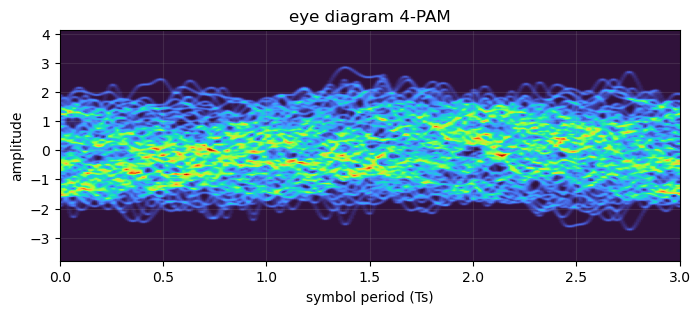

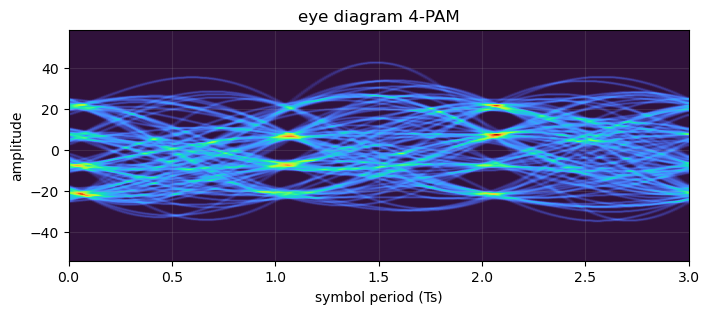

In [7]:
# parâmetros da simulação
M   = 4             # ordem do formato de modulação
SpS = 16            # Amostras por símbolo
Rs  = 100e6         # Taxa de símbolos
Ts  = 1/Rs          # Período de símbolo em segundos
Fa  = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta  = 1/Fa          # Período de amostragem

# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size = int(200000*np.log2(M)))

# generate ook modulated symbol sequence
symbTx = modulateGray(bitsTx, M, 'pam')    
symbTx = pnorm(symbTx) # power normalization

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso 
pulse = pulseShape('rrc', SpS, N=4096, alpha=0.01)
pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx = firFilter(pulse, symbolsUp)
sigTx = sigTx.real

# ruído gaussiano branco
Namostras = sigTx.size
σ2  = 0.0050 # variância
μ   = 0      # média

σ      = sqrt(σ2*SpS) 
ruido  = normal(μ, σ, Namostras)

# diagrama de olho
Nsamples = sigTx.size
eyediagram(sigTx+ruido, Nsamples, SpS, plotlabel= str(M)+'-PAM', ptype='fancy')
eyediagram(firFilter(pulse, sigTx+ruido), Nsamples, SpS, plotlabel= str(M)+'-PAM', ptype='fancy')

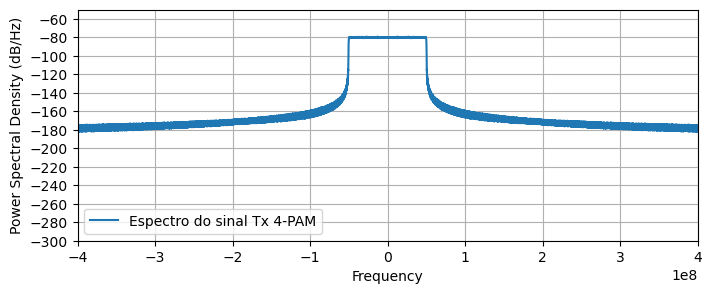

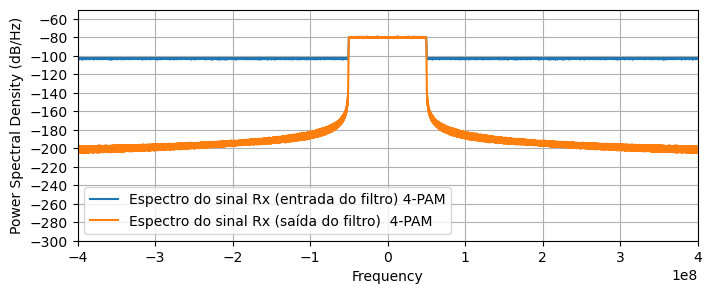

In [8]:
# plot PSD
plt.figure();
plt.xlim(-4*Rs,4*Rs);
plt.ylim(-300,-50);
plt.psd(sigTx,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal Tx '+ str(M) +'-PAM')
plt.legend(loc='lower left');

plt.figure();
plt.xlim(-4*Rs,4*Rs);
plt.ylim(-300,-50);
plt.psd(sigTx+ruido,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal Rx (entrada do filtro) '+ str(M) +'-PAM')
plt.psd(pnorm(firFilter(pulse, sigTx+ruido)),Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal Rx (saída do filtro)  '+ str(M) +'-PAM')
plt.legend(loc='lower left');

## Detectores ótimos

Após a etapa de demodulação, seja por banco de correlatores como por  banco de filtros casados, o receptor dispõe de um vetor de amostras $\mathbf{r} = [r_1, r_2, \dots, r_N]$, com distribuição condicional dada por

$$\begin{equation}\label{pdf_conj_4}
p\left(\mathbf{r}|\mathbf{s}_m\right)=\frac{1}{\left(\pi N_0\right)^{N/2}} \exp \left[-\sum_{k=1}^N \frac{\left(r_k-s_{m k}\right)^2}{N_0}\right], \quad m=1,2, \ldots, M,
\end{equation}$$

em que $s_{m k}$ são as componentes ortogonais dos símbolos da constelação e $N_0/2$ a variância do ruído gaussiano adicionado pelo canal. O conjunto de amostras no vetor $\mathbf{r}$ é uma *estatística suficiente*, ou seja, contém toda a informação disponível sobre o sinal transmitido. 

Na sequência, baseado no vetor $\mathbf{r}$, o receptor deve tomar uma decisão sobre que símbolo foi transmitido. Esta função é realizada pelo detector. Ao final de cada intervalo de sinalização, baseado na observação de $\mathbf{r}$, o detector deve decidir que símbolo $\mathbf{s}_m$ foi transmitido. Nesse contexto, podemos implementar diversas regras que o detector pode seguir no processo de decisão. Entretanto, nos interessa definir a melhor regra possível, ou seja, a regra de decisão que otimiza o desempenho do detector. A regra de detecção ótima é aquela que maximiza a probabilidade de acerto do símbolo transmitido, ou equivalentemente, minimiza a probabilidade de erro. Para tanto, considera-se uma regra de decisão baseada no cálculo das probabilidades *a posteriori*

$$\begin{equation}\label{posterior_1}
P\left(\text{símbolo }\mathbf{s}_m \text{ foi transmitido}|\mathbf{r}\right), \quad m=1,2, \ldots, M,
\end{equation}$$

abreviadas para $P\left(\mathbf{s}_m|\mathbf{r}\right)$. A regra de decisão a ser implementada consiste em selecionar o símbolo que corresponde ao máximo do conjunto de probabilidades $\left\lbrace P\left(\mathbf{s}_m|\mathbf{r}\right) \right\rbrace$. Será demonstrado que esta regra é ótima, ou seja, é aquela que maximiza a probabilidade de acerto no processo de decisão.

### Critério de decisão MAP
Inicialmente, antes de observar $\mathbf{r}$, o receptor conhece apenas as probabilidades $P(\mathbf{s}_m)$ do transmissor ter enviado cada símbolo $\mathbf{s}_m$. Estas probabilidades representam um conhecimento prévio do receptor acerca dos sinais transmitidos, sendo denominadas probabilidades *a priori*. Uma vez observada a saída do canal $\mathbf{r}$, o receptor pode melhorar a sua estimativa sobre o símbolo transmitido calculando as probabilidades *a posteriori* $P\left(\mathbf{s}_m|\mathbf{r}\right)$ para cada símbolo da constelação e, então, decidir por aquele de maior probabilidade. Este critério de decisão é conhecido como critério de máxima probabilidade *a posteriori* (*maximum a posteriori probability* - MAP).

Utilizando a regra de Bayes, podemos escrever

$$
\begin{align}
P\left(\mathbf{s}_m|\mathbf{r}\right)&=\frac{p\left(\mathbf{r}|\mathbf{s}_m\right) P\left(\mathbf{s}_m\right)}{p(\mathbf{r})}\nonumber\\
&= \frac{p\left(\mathbf{r}|\mathbf{s}_m\right) P\left(\mathbf{s}_m\right)}{\sum_{m=1}^M p\left(\mathbf{r}|\mathbf{s}_m\right) P\left(\mathbf{s}_m\right)}\label{posterior_2}
\end{align}
$$

em que $p\left(\mathbf{r}|\mathbf{s}_m\right)$ é a função densidade de probabilidade condicional de $\mathbf{r}$ dado que $\mathbf{s}_m$ foi transmitido, $P\left(\mathbf{s}_m\right)$ é a probabilidade *a priori* de $\mathbf{s}_m$ ter sido transmitido.

Perceba que no cálculo de $P\left(\mathbf{s}_m|\mathbf{r}\right),\; m=1,2, \ldots, M$, o somatório no denominador da equação ($\ref{posterior_2}$) é independente de $m$, representando apenas um fator de normalização. Logo, seja $\hat{\mathbf{s}}_m$ o símbolo decidido pelo detector, o critério MAP de decisão pode ser expresso como

$$
\begin{align}
\hat{\mathbf{s}}_m &= \arg\max_{\mathbf{s}_m}P\left(\mathbf{s}_m|\mathbf{r}\right)\nonumber\\
&= \arg\max_{\mathbf{s}_m}p\left(\mathbf{r}|\mathbf{s}_m\right)P\left(\mathbf{s}_m\right)\label{MAP_crit}
\end{align}
$$

### Critério de decisão ML

Para o caso em que os símbolos enviados pelo transmissor são equiprováveis, $P\left(\mathbf{s}_m\right) = \frac{1}{M},\; m=1,2, \ldots, M$,  e o critério de decisão MAP definido em ($\ref{MAP_crit}$) pode ser simplificado para

$$
\begin{align}
\hat{\mathbf{s}}_m &= \arg\max_{\mathbf{s}_m}P\left(\mathbf{s}_m|\mathbf{r}\right)\nonumber\\
&= \arg\max_{\mathbf{s}_m}p\left(\mathbf{r}|\mathbf{s}_m\right)\label{ML_crit}
\end{align}
$$

Desse modo, o critério de decisão ótima requer apenas da avaliação da função $p\left(\mathbf{r}|\mathbf{s}_m\right)$. Uma vez que esta densidade de probabilidade condicional (ou qualquer função monotônica da mesma) é conhecida como *função de verossimilhança*, o novo critério denomina-se *critério de máxima verossimilhança*.

### Métricas de decisão

Para o canal AWGN, a função de verossimilhança é dada pela equação ($\ref{pdf_conj_4}$). Por conveniência na simplificação dos cálculos a serem realizados no receptor, utiliza-se a função logaritmo natural de $p\left(\mathbf{r}|\mathbf{s}_m\right)$, que é uma função monotônica, de modo que

$$
\begin{equation}\label{loglikeli}
\ln p\left(\mathbf{r}|\mathbf{s}_m\right)=\frac{-N}{2} \ln \left(\pi N_0\right)-\frac{1}{N_0} \sum_{k=1}^N\left(r_k-s_{m k}\right)^2.
\end{equation}
$$

Maximizar $\ln p\left(\mathbf{r}|\mathbf{s}_m\right)$ equivale a minimizar o somatório do lado direito de ($\ref{loglikeli}$). Por outro lado, este somatório corresponde ao quadrado da distância euclidiana entre $\mathbf{r}$ e $\mathbf{s}_m$. Logo, podemos definir a seguinte métrica $D\left(\mathbf{r}, \mathbf{s}_m\right)$ de distância euclidiana

$$
\begin{equation}\label{metric_dist}
D\left(\mathbf{r}, \mathbf{s}_m\right)=\sum_{k=1}^N\left(r_k-s_{m k}\right)^2 = \| \mathbf{r} - \mathbf{s}_m \|^2.
\end{equation}
$$

Portanto, para a aplicação do critério ML é suficiente que o receptor decida pelo símbolo $\mathbf{s}_m$ que está mais próximo ao sinal recebido $\mathbf{r}$.

Um segundo critério pode ser derivado a partir da expansão de ($\ref{metric_dist}$) em
$$
\begin{align}
D\left(\mathbf{r}, \mathbf{s}_m\right) & =\sum_{n=1}^N r_n^2-2 \sum_{n=1}^N r_n s_{m n}+\sum_{n=1}^N s_{m n}^2 \\
&=\|\mathbf{r}\|^2-2 \mathbf{r} \cdot \mathbf{s}_m+\left\|\mathbf{s}_m\right\|^2, \quad m=1,2, \ldots, M.
\end{align}
$$

Notando que $\|\mathbf{r}\|^2$ é um termo comum a todas $D\left(\mathbf{r}, \mathbf{s}_m\right)$, este pode ser suprimido e a métrica pode ser reescrita como

$$
\begin{equation}\label{metric_dist2}
D^{\prime}\left(\mathbf{r}, \mathbf{s}_m\right)=-2 \mathbf{r} \cdot \mathbf{s}_m+\left\|\mathbf{s}_m\right\|^2.
\end{equation}
$$

Minimizar ($\ref{metric_dist2}$) equivale a maximizar 

$$
\begin{equation}\label{metric_corr}
C \left(\mathbf{r}, \mathbf{s}_m\right) = 2 \mathbf{r} \cdot \mathbf{s}_m-\left\|\mathbf{s}_m\right\|^2.
\end{equation}
$$

A métrica $C \left(\mathbf{r}, \mathbf{s}_m\right)$ é denominada *métrica de correlação*. Nesta métrica, o receptor decide pelo símbolo $\mathbf{s}_m$ que apresenta maior métrica de correlação com o $\mathbf{r}$.

Tanto $D\left(\mathbf{r}, \mathbf{s}_m\right)$ quanto $C\left(\mathbf{r}, \mathbf{s}_m\right)$ são métricas que podem ser utilizadas no caso de todos os símbolos $\mathbf{s}_m$ serem equiprováveis. Entretanto, caso essa condição não seja satisfeita, o critério MAP deve ser aplicado diretamente, o que significa maximizar a seguinte métrica de probabilidade *a posteriori*

$$
\begin{equation}\label{metric_prob}
\operatorname{PM}\left(\mathbf{r}, \mathbf{s}_m\right)= p\left(\mathbf{r}|\mathbf{s}_m\right) P\left(\mathbf{s}_m\right).
\end{equation}
$$

$$
\begin{align}\label{metric_prob_2}
\ln\left[p\left(\mathbf{r}|\mathbf{s}_m\right)P\left(\mathbf{s}_m\right)\right]&=\frac{-N}{2} \ln \left(\pi N_0\right)-\frac{1}{N_0} \sum_{k=1}^N\left(r_k-s_{m k}\right)^2 + \ln P\left(\mathbf{s}_m\right).\nonumber\\
&\propto \sigma_n^2\ln \left(P\left(\mathbf{s}_m\right)\right) - \sum_{k=1}^N\left(r_k-s_{m k}\right)^2 \nonumber\\
\end{align}
$$

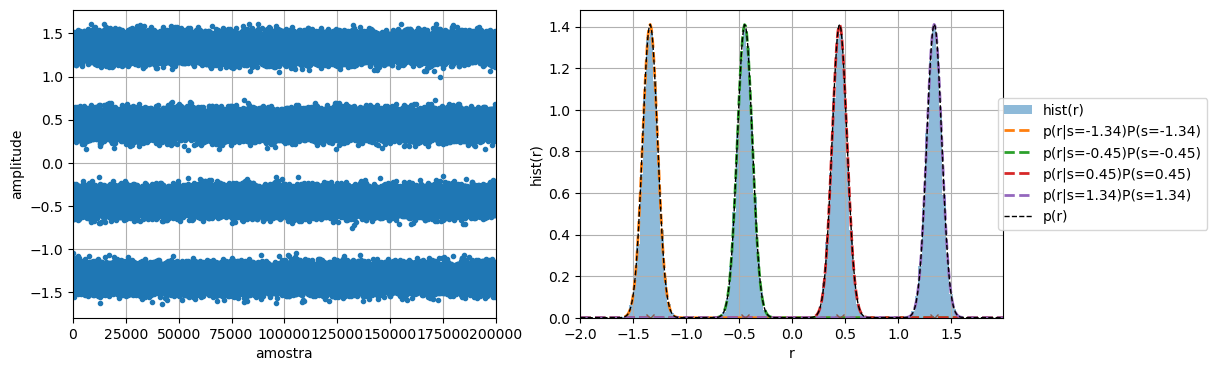

In [9]:
# ruído gaussiano branco
σ2  = 0.005  # variância
μ   = 0      # média

σ     = sqrt(σ2*SpS) 
ruido = normal(μ, σ, sigTx.size)  

constSymb = np.unique(symbTx)

# filtro casado
sigRx = firFilter(pulse, sigTx+ruido)
sigRx = pnorm(sigRx)

# downsampling
r = sigRx[1::SpS]

# plota valores de r e histograma
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,4))

ax1.plot(r,'.',linewidth = 0.8);
ax1.grid()
ax1.set_xlabel('amostra')
ax1.set_ylabel('amplitude')
ax1.set_xlim(0,r.size);

ax2.hist(r, density=True, bins=100, label = 'hist(r)',alpha=0.5);

x = np.arange(-2, 2, 0.01)
π = np.pi
pdf = 0
for sm in constSymb:
    pdf_c = 1/np.sqrt(2*π*σ2)*np.exp(-(x-sm)**2/(2*σ2))*(1/M) 
    pdf += pdf_c
    ax2.plot(x, pdf_c, '--', label = f'p(r|s={sm:.2f})P(s={sm:.2f})', linewidth=2);
    
ax2.plot(x, pdf, 'k--', label = 'p(r)', linewidth=1);    
ax2.grid()
ax2.legend(loc='right', bbox_to_anchor=(1.5, 0.5))
ax2.set_xlabel('r')
ax2.set_ylabel('hist(r)');
ax2.plot(np.unique(symbTx),np.zeros(M),'x');
ax2.set_xlim(min(x), max(x));

### Implementação de detectores MAP e ML

In [10]:
from numba import njit
import numpy as np

@njit
def detector(r, σ2, constSymb, px=None, rule='MAP'):
    """
    Perform symbol detection using either the MAP (Maximum A Posteriori) or ML (Maximum Likelihood) rule.

    Parameters:
        r (ndarray): The received signal.
        σ2 (float): The noise variance.
        constSymb (ndarray): The constellation symbols.
        px (ndarray, optional): The prior probabilities of each symbol. If None, uniform priors are assumed.
        rule (str, optional): The detection rule to use. Either 'MAP' (default) or 'ML'.

    Returns:
        tuple: A tuple containing:
            - ndarray: The detected symbols.
            - ndarray: The indices of the detected symbols in the constellation.

    """
    if px is None or rule == 'ML':
        px = 1 / constSymb.size * np.ones(constSymb.size)
           
    decided = np.zeros(r.size, dtype=np.complex64) 
    indDec = np.zeros(r.size, dtype=np.int64) 
    π = np.pi  
    
    if rule == 'MAP':
        for ii, ri in enumerate(r): # for each received symbol        
            log_probMetric = np.zeros(constSymb.size)

            # calculate MAP probability metric        
            # calculate log(P(sm|r)) = log(p(r|sm)*P(sm)) for m= 1,2,...,M
            log_probMetric = - np.abs(ri - constSymb)**2 / σ2 + np.log(px)

            # find the constellation symbol with the largest P(sm|r)       
            indDec[ii] = np.argmax(log_probMetric)

            # make the decision in favor of the symbol with the largest metric
            decided[ii] = constSymb[indDec[ii]]
            
    elif rule == 'ML':      
        for ii, ri in enumerate(r): # for each received symbol        
            distMetric = np.zeros(constSymb.size)        
            # calculate distance metric   

            # calculate |r-sm|**2, for m= 1,2,...,M
            distMetric = np.abs(ri - constSymb)**2

            # find the constellation symbol with the smallest distance metric       
            indDec[ii] = np.argmin(distMetric)

            # make the decision in favor of the symbol with the smallest metric
            decided[ii] = constSymb[indDec[ii]]
    else:
        print('Detection rule should be either MAP or ML')
        
    
    return decided, indDec

In [11]:
def findLimiars(constSymb, σ2=1, px=None, rule='MAP'):
    
    σ2_x = σ2/2
    σ2_y = σ2/2
    
    M = constSymb.size
    
    if px is None or rule == 'ML':
        px = 1/M*np.ones(M)  
        
    xmin = np.min(constSymb.real)
    ymin = np.min(constSymb.imag)
    xmax = np.max(constSymb.real)
    ymax = np.max(constSymb.imag)
        
    x = np.linspace(xmin, xmax, 2000)
    y = np.linspace(ymin, ymax, 2000)

    constSymb = np.round(constSymb,2)

    x_const = np.sort(np.unique(constSymb.real))
    y_const = np.sort(np.unique(constSymb.imag))

    lx = np.zeros(x_const.size-1)
    ly = np.zeros(x_const.size-1)

    for ii in range(x_const.size):
        if ii == 0:
            pass
        else:            
            pivot1 = x_const[ii-1] + 1j*y_const[0]
            pivot2 = x_const[ii] + 1j*y_const[0]
            
            x = np.linspace(pivot1.real, pivot2.real, 1000)
            
            p1 = px[constSymb == pivot1]
            p2 = px[constSymb == pivot2]
            
            metric1 = - np.abs(x - x_const[ii-1])**2 / (2*σ2_x) + np.log(p1)
            metric2 = - np.abs(x - x_const[ii]  )**2 / (2*σ2_x) + np.log(p2)
                                    
            lx[ii-1] = np.round(x[np.argmin(np.abs(metric1 - metric2))],2)

    for ii in range(y_const.size):

        if ii == 0:
            pass
        else:            
            pivot1 = x_const[0] + 1j*y_const[ii-1]
            pivot2 = x_const[0] + 1j*y_const[ii]
            
            y = np.linspace(pivot1.imag, pivot2.imag, 1000)
            
            p1 = px[constSymb == pivot1]
            p2 = px[constSymb == pivot2]

            metric1 = - np.abs(y - y_const[ii-1])**2 / (2*σ2_y)  + np.log(p1)
            metric2 = - np.abs(y - y_const[ii])**2 / (2*σ2_y) + np.log(p2)

            ly[ii-1] = np.round(y[np.argmin(np.abs(metric1 - metric2))],2)

    return lx, ly

### Exemplo: sinal M-PAM equiprovável

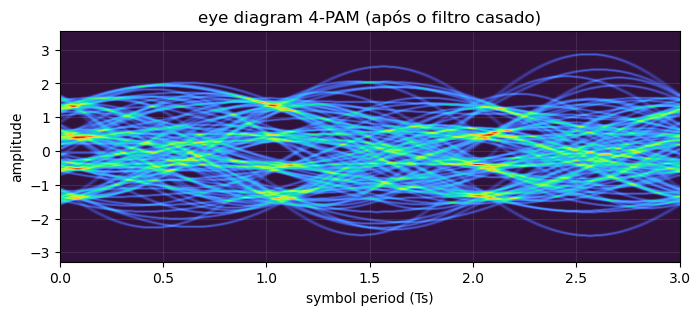

In [12]:
# select PAM order
M = 4

# parâmetros da simulação
SpS = 16            # Amostras por símbolo
Rs  = 100e6         # Taxa de símbolos
Ts  = 1/Rs          # Período de símbolo em segundos
Fa  = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta  = 1/Fa          # Período de amostragem

# get constellation    
constSymb = grayMapping(M, 'pam')  # constellation
constSymb = pnorm(constSymb) 

# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size = int(500000*np.log2(M)))

# generate modulated symbol sequence
symbTx = modulateGray(bitsTx, M, 'pam')    
symbTx = pnorm(symbTx) # power normalization

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso NRZ típico
pulse = pulseShape('rrc', SpS, N=4096, alpha=0.01)
pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx = firFilter(pulse, symbolsUp)
sigTx = sigTx.real
sigTx = pnorm(sigTx)

# ruído gaussiano branco
Namostras = sigTx.size
σ2  = 0.015 # variância
μ   = 0      # média

σ      = sqrt(σ2*SpS) 
ruido  = normal(μ, σ, Namostras)

# filtro casado
sigRx = firFilter(pulse, sigTx+ruido)
sigRx = pnorm(sigRx)

# downsampling
r = sigRx[1::SpS]

# diagrama de olho
Nsamples = 200000*SpS
eyediagram(sigRx, Nsamples, SpS, plotlabel= str(M)+'-PAM (após o filtro casado)', ptype='fancy')

In [13]:
dec, pos = detector(r, σ2, constSymb, rule='MAP') # detector

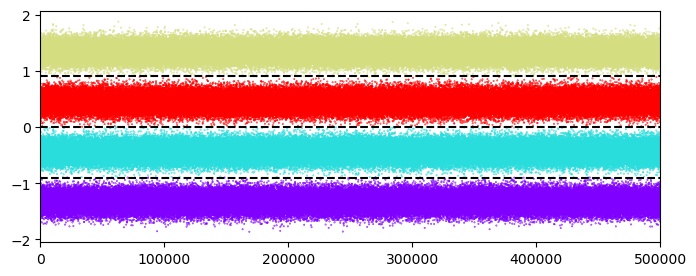

In [14]:
# plota símbolos recebidos e decisões
n_colors = M
colors = cm.rainbow(np.linspace(0, 1, n_colors))
index = np.arange(0,dec.size)
plt.scatter(index, r,c=[colors[ind] for ind in pos], marker='.', s = 0.5);
plt.xlim(0, dec.size);

lx, _ = findLimiars(constSymb, σ2=σ2)
#plt.hlines(constSymb, 0, dec.size, colors='black', linewidth=1);
plt.hlines(lx, 0, dec.size, colors='black', linestyles='dashed');

In [15]:
from optic.comm.metrics import fastBERcalc, theoryBER

ind = np.arange(100,dec.size-100)

SER = 1 - np.sum( np.isclose(dec, symbTx, rtol=1e-2) )/dec.size # calcula SER

SNRb = 10*np.log10(signal_power(sigTx)/(2*σ2)/np.log2(M))

BER_th = theoryBER(M, SNRb,'pam')

print(f'SNRb = {SNRb:.2f} dB')
print(f'SER = {SER:.2e}')
print(f'SER(teoria) = {BER_th*np.log2(M):.2e}')

SNRb = 12.22 dB
SER = 1.72e-04
SER(teoria) = 1.96e-04


### Exemplo: sinal M-PAM não-equiprovável

In [16]:
def maxwellBolt(λ, const):
    
    p = np.zeros(const.size)
    
    for ind, x in enumerate(const):
        p[ind] = np.exp(-λ*np.abs(x)**2)
        
    p = p/np.sum(p)
    
    return p

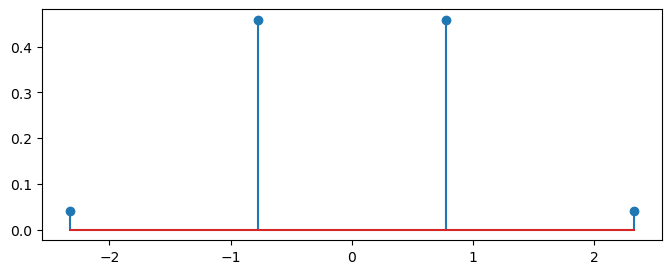

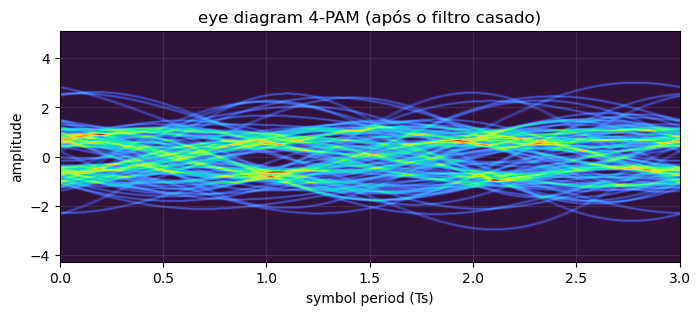

In [17]:
# select PAM order
M = 4

# parâmetros da simulação
SpS = 16            # Amostras por símbolo
Rs  = 100e6         # Taxa de símbolos
Ts  = 1/Rs          # Período de símbolo em segundos
Fa  = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta  = 1/Fa          # Período de amostragem

# gera constelação    
constSymb = grayMapping(M, 'pam')  # constellation

# define probabilidades de símbolo
constSymb = pnorm(constSymb)

PS = 1.5
probSymb = maxwellBolt(PS, constSymb) 
Es = np.sum(( np.abs(constSymb) ** 2 ) * probSymb)
constSymb = constSymb/np.sqrt(Es)

plt.stem(constSymb, probSymb)

# gera sequência de símbolos modulados
symbTx = np.random.choice(constSymb, 200000, p=probSymb)
symbTx = pnorm(symbTx) # power normalization
    
# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso 
pulse = pulseShape('rrc', SpS, N=4096, alpha=0.01)
pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx = firFilter(pulse, symbolsUp)
sigTx = sigTx.real
sigTx = pnorm(sigTx)

# ruído gaussiano branco
Namostras = sigTx.size
σ2  = 0.10 # variância
μ   = 0   # média

σ      = sqrt(σ2*SpS) 
ruido  = normal(μ, σ, Namostras)

# filtro casado
sigRx = firFilter(pulse, sigTx+ruido)
sigRx = pnorm(sigRx)

# downsampling
r = sigRx[1::SpS]

# diagrama de olho
Nsamples = 200000*SpS
eyediagram(sigRx, Nsamples, SpS, plotlabel= str(M)+'-PAM (após o filtro casado)', ptype='fancy')

In [18]:
dec, pos = detector(r, σ2, constSymb, px=probSymb, rule='MAP') # detector

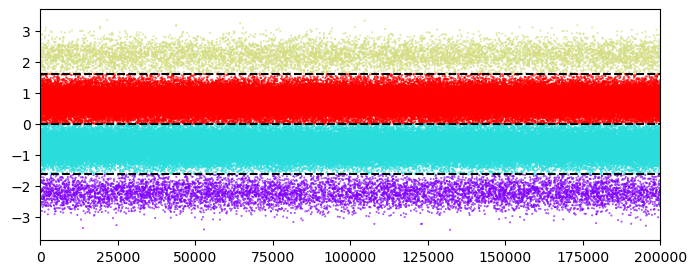

In [19]:
# plota símbolos recebidos e decisões
n_colors = M
colors = cm.rainbow(np.linspace(0, 1, n_colors))
index = np.arange(0,dec.size)
plt.scatter(index, r,c=[colors[ind] for ind in pos], marker='.', s = 0.5);
plt.xlim(0, dec.size);

lx, _ = findLimiars(constSymb, σ2=σ2, px=probSymb)
#plt.hlines(constSymb, 0, dec.size, colors='black', linewidth=1);
plt.hlines(lx, 0, dec.size, colors='black', linestyles='dashed');

In [20]:
ind = np.arange(1000,dec.size-1000)

SER = 1 - np.sum( np.isclose(dec, symbTx, atol=1e-2) )/dec.size # calcula SER

SNRb = 10*np.log10(signal_power(sigTx)/(2*σ2)/np.log2(M))

print(f'SNRb = {SNRb:.2f} dB')
print(f'SER = {SER:.2e}')

SNRb = 3.98 dB
SER = 1.00e-02


### Exemplo: sinal M-QAM equiprovável

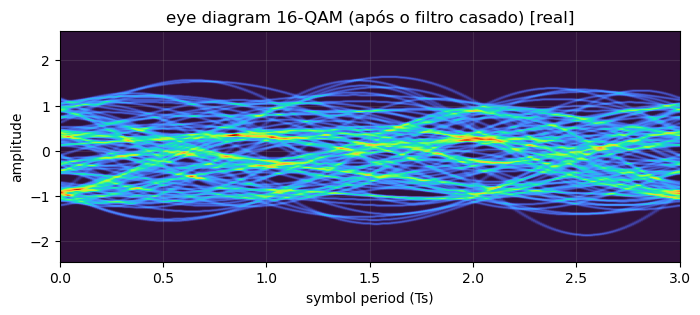

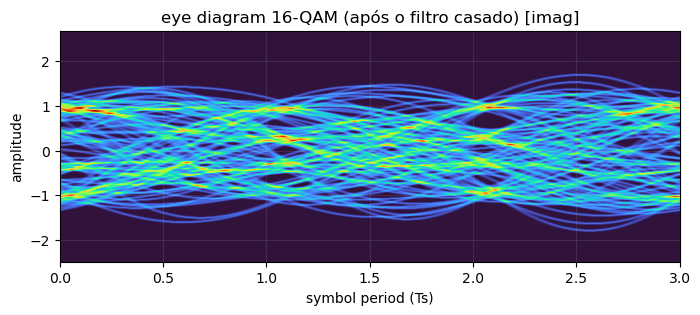

In [21]:
# select QAM order
M = 16

# parâmetros da simulação
SpS = 16            # Amostras por símbolo
Rs  = 100e6         # Taxa de símbolos
Ts  = 1/Rs          # Período de símbolo em segundos
Fa  = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta  = 1/Fa          # Período de amostragem

# get constellation    
constSymb = grayMapping(M, 'qam')  # constellation
constSymb = pnorm(constSymb) 

# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size = int(500000*np.log2(M)))

# generate modulated symbol sequence
symbTx = modulateGray(bitsTx, M, 'qam')    
symbTx = pnorm(symbTx) # power normalization

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso NRZ típico
pulse = pulseShape('rrc', SpS, N=4096, alpha=0.01)
pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx = firFilter(pulse, symbolsUp)
sigTx = pnorm(sigTx)

# ruído gaussiano branco
Namostras = sigTx.size
σ2  = 0.025 # variância
μ   = 0      # média

σ      = sqrt(σ2*SpS) 
ruido  = 1/np.sqrt(2)*(normal(μ, σ, Namostras) + 1j*normal(μ, σ, Namostras))

# filtro casado
sigRx = firFilter(pulse, sigTx+ruido)
sigRx = pnorm(sigRx)

# downsampling
r = sigRx[1::SpS]

# diagrama de olho
Nsamples = 200000*SpS
eyediagram(sigRx, Nsamples, SpS, plotlabel= str(M)+'-QAM (após o filtro casado)', ptype='fancy')

In [22]:
dec, pos = detector(r, σ2, constSymb, rule='ML') # detector

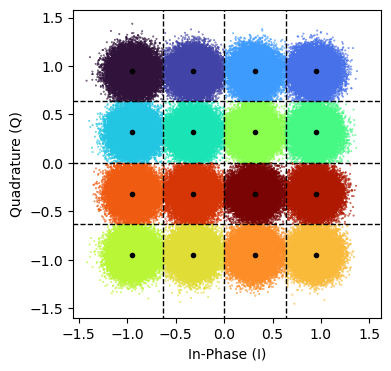

In [23]:
# plota símbolos recebidos e limiares de decisão
fig, ax = plotColoredConst(r, constSymb, SNR=10*np.log10(1/σ2), cmap = cm.turbo)
fig.set_size_inches(4, 4)
plt.plot(constSymb.real, constSymb.imag,'ko', markersize=3);

lx, ly = findLimiars(constSymb, σ2=σ2)

plt.hlines(ly, -3, 3, colors='black', linestyles='dashed', linewidth=1);
plt.vlines(lx, -3, 3, colors='black', linestyles='dashed', linewidth=1);

In [24]:
ind = np.arange(100,dec.size-100)

SER = 1 - np.sum( np.isclose(dec, symbTx, rtol=1e-2) )/dec.size # calcula SER

SNRb = 10*np.log10(signal_power(sigTx)/σ2/np.log2(M))

BER_th = theoryBER(M, SNRb,'qam')

print(f'SNRb = {SNRb:.2f} dB')
print(f'SER = {SER:.2e}')
print(f'SER(teoria) = {BER_th*np.log2(M):.2e}')

SNRb = 10.00 dB
SER = 7.10e-03
SER(teoria) = 7.02e-03


### Exemplo: sinal M-QAM não-equiprovável

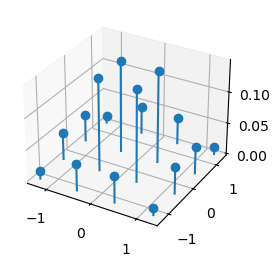

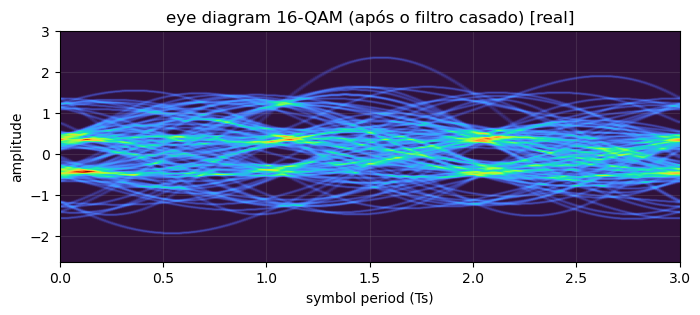

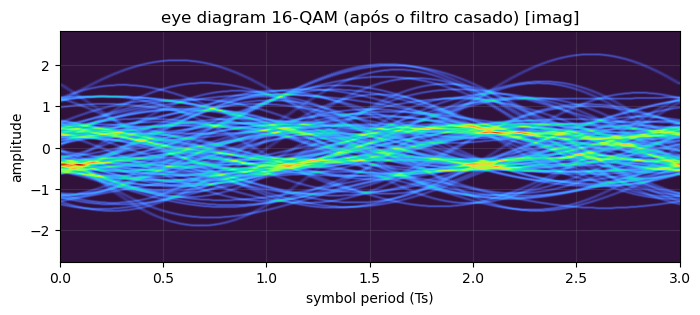

In [25]:
# select PAM order
M = 16

# parâmetros da simulação
SpS = 16            # Amostras por símbolo
Rs  = 100e6         # Taxa de símbolos
Ts  = 1/Rs          # Período de símbolo em segundos
Fa  = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta  = 1/Fa          # Período de amostragem

# gera constelação    
constSymb = grayMapping(M, 'qam')  # constellation

# define probabilidades de símbolo
constSymb = pnorm(constSymb)

PS = 1.5
probSymb = maxwellBolt(PS, constSymb) 
Es = np.sum(( np.abs(constSymb) ** 2 ) * probSymb)
constSymb = constSymb/np.sqrt(Es)

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.stem(constSymb.real,constSymb.imag, probSymb, basefmt=" ")

# gera sequência de símbolos modulados
symbTx = np.random.choice(constSymb, 200000, p=probSymb)
symbTx = pnorm(symbTx) # power normalization
    
# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso 
pulse = pulseShape('rrc', SpS, N=4096, alpha=0.01)
pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx = firFilter(pulse, symbolsUp)
sigTx = pnorm(sigTx)

# ruído gaussiano branco
Namostras = sigTx.size
σ2  = 0.025 # variância
μ   = 0   # média

σ      = sqrt(σ2*SpS) 
ruido  = 1/np.sqrt(2)*(normal(μ, σ, Namostras) + 1j*normal(μ, σ, Namostras))


# filtro casado
sigRx = firFilter(pulse, sigTx+ruido)
sigRx = pnorm(sigRx)

# downsampling
r = sigRx[2::SpS]

# diagrama de olho
Nsamples = 200000*SpS
eyediagram(sigRx, Nsamples, SpS, plotlabel= str(M)+'-QAM (após o filtro casado)', ptype='fancy')

In [26]:
dec, pos = detector(r, σ2, constSymb, px=probSymb, rule='MAP') # detector

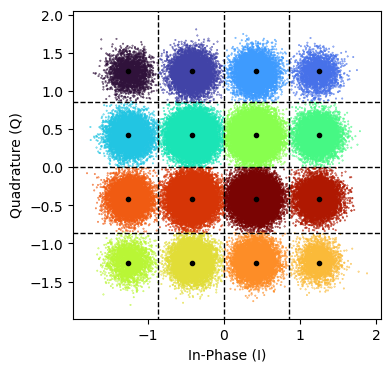

In [27]:
# plota símbolos recebidos e limiares de decisão
fig, ax = plotColoredConst(r, constSymb, SNR=10*np.log10(1/σ2), px=probSymb, rule='MAP', cmap = cm.turbo)
fig.set_size_inches(4, 4)
plt.plot(constSymb.real, constSymb.imag,'ko', markersize=3);

lx, ly = findLimiars(constSymb, σ2=σ2, px=probSymb)
plt.hlines(ly, -3, 3, colors='black', linestyles='dashed', linewidth=1);
plt.vlines(lx, -3, 3, colors='black', linestyles='dashed', linewidth=1);

In [28]:
ind = np.arange(100,dec.size-100)

SER = 1 - np.sum( np.isclose(dec[ind], symbTx[ind], rtol=1e-2) )/dec.size # calcula SER

SNRb = 10*np.log10(signal_power(sigTx)/σ2/np.log2(M))

print(f'SNRb = {SNRb:.2f} dB')
print(f'SER = {SER:.2e}')

SNRb = 10.00 dB
SER = 4.87e-03


## Cálculo da probabilidade de erro para modulações sem memória em canais AWGN

### Modulações binárias antipodais

Considere o caso da modulação binária PAM, em que o transmissor envia os sinais $s_1(t) = g(t)$ e $s_2(t) = -g(t)$. Seja $E_g = \int_{0}^{T_s} g^2(t)dt$ a energia do pulso, a base ortonormal para os sinais ${s_1(t),s_2(t)}$ contém apenas uma função dada por $u(t) = \frac{g(t)}{\sqrt{E_g}}$. Logo, a constelação da modulação possui dois símbolos representados por $s_1 = -\sqrt{E_g}$ e $s_2 = \sqrt{E_g}$. Considere que os dois símbolos são equiprováveis, i.e. $P(s_1) = P(s_2)= \frac{1}{2}$.

Considerando que os sinais são transmitidos por um canal AWGN, num dado instante de sinalização a saída $r$ do demodulador será dada por

$$\begin{equation}
r = s + n,
\end{equation}$$

em que $n$ é uma variável aleatória gaussiana de média 0 e variância $\sigma^2 = \frac{N_0}{2}$. Neste caso, a regra de decisão ótima correspondente ao critério MAP consiste na comparação entre o valor de $r$ e o limiar de decisão $l_d$. Se $r<l_d$, decide-se que $s=s_1$. Caso contrário, decide-se que $s=s_2$. No caso de sinais binários equiprováveis, temos que $l_d = 0$.
Teremos, então, as seguintes distribuições condicionais de $r$ dado $s$

$$
\begin{align}
p\left(r|s_1\right)&=\frac{1}{\sqrt{\pi N_0}} e^{-\left(r+\sqrt{\mathcal{E}_g}\right)^2 / N_0} \nonumber\\
p\left(r|s_2\right)&=\frac{1}{\sqrt{\pi N_0}} e^{-\left(r-\sqrt{\mathcal{E}_g}\right)^2 / N_0} \nonumber
\end{align}
$$
Seja $P(e)$ a probabilidade de ocorrência de um erro no processo de detecção implementado no receptor, temos que

$$
\begin{align}
P(e|s_1) = P\left(r>0|s_1\right) & =\int_{0}^\infty p\left(r|s_1\right) d r \nonumber\\
& =\frac{1}{\sqrt{\pi N_0}} \int_{0}^\infty e^{-\left(r + \sqrt{E_g}\right)^2 / N_0} d r \nonumber\\
& =\frac{1}{\sqrt{2 \pi}} \int_{\sqrt{2 E_g / N_0}}^{\infty} e^{-x^2 / 2} d x \nonumber\\
& =Q\left(\sqrt{\frac{2 E_g}{N_0}}\right)
\end{align}
$$

em que $Q(x)=\frac{1}{\sqrt{2 \pi}} \int_x^{\infty} \exp \left(-\frac{u^2}{2}\right) d u =\frac{1}{2} \operatorname{erfc}\left(\frac{x}{\sqrt{2}}\right)$.

De maneira análoga, temos

$$
\begin{align}
P(e|s_2) = P\left(r<0|s_1\right) & =\int_{-\infty}^0 p\left(r|s_2\right) d r \nonumber\\
& =\frac{1}{\sqrt{\pi N_0}} \int_{-\infty}^0 e^{-\left(r - \sqrt{E_g}\right)^2 / N_0} d r\nonumber \\
& =\frac{1}{\sqrt{2 \pi}} \int_{-\infty}^{-\sqrt{2 E_g / N_0}} e^{-x^2 / 2} d x \nonumber\\
& =\frac{1}{\sqrt{2 \pi}} \int_{\sqrt{2 E_g / N_0}}^{\infty} e^{-x^2 / 2} d x \nonumber\\
& =Q\left(\sqrt{\frac{2 E_g}{N_0}}\right)
\end{align}
$$

Logo, a probabilidade de erro $P(e)$ é dada por

$$
\begin{align}
P(e) & =\frac{1}{2} P\left(e|s_1\right)+\frac{1}{2} P\left(e|s_2\right) \\
& = Q\left(\sqrt{\frac{2 E_g}{N_0}}\right)
\end{align}
$$

Perceba que a probabilidade de erro é função apenas da relação sinal-ruído $\mathrm{SNR} = \frac{E_s}{\sigma_n^2} = \frac{2E_g}{N_0}$ na entrada do receptor.

In [29]:
from scipy.special import erfc

def Q(x):
    return 0.5*erfc(x/np.sqrt(2))

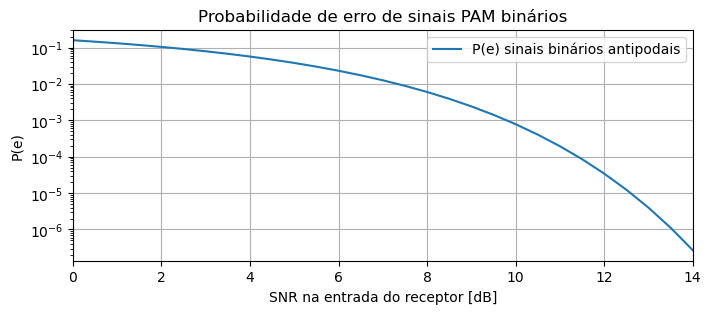

In [30]:
SNRdB = np.arange(0,14.5,0.5)
SNR = 10**(SNRdB/10)

Pe = Q(np.sqrt(SNR))

plt.figure()
plt.semilogy(SNRdB, Pe, '-', label='P(e) sinais binários antipodais')
plt.xlabel('SNR na entrada do receptor [dB]')
plt.ylabel('P(e)')
plt.title('Probabilidade de erro de sinais PAM binários')
plt.xlim(min(SNRdB), max(SNRdB))
plt.legend()
plt.grid();

### Modulações binárias ortogonais

Considere que disponhamos de um espaço de sinais bidimensional para gerar o conjunto de sinais da modulação. Suponha que escolhamos o seguinte par ortogonal de vetores para compor um esquema de modulação binário

$$
\begin{aligned}
& \mathbf{s}_1=\left[\sqrt{E_g}, 0\right] \\
& \mathbf{s}_2=\left[0, \sqrt{E}_g\right]
\end{aligned}
$$

em que $E_g$ representa a energia média de cada um dos sinais. Note que a distância euclidiana entre $\mathbf{s}_1$ e $\mathbf{s}_2$ é $d_{12} = \sqrt{2E_g}$. 

Assumindo que o sinal $\mathbf{s}_1$ foi transmitido, as saída do demodulador será dada por

$$
\begin{equation}
\boldsymbol{r}=\left[\sqrt{E_g}+n_1, n_2\right]
\end{equation}
$$

Uma vez que ambos os símbolos são equiprováveis e possuem a mesma energia, a métrica de correlação pode ser utilizada no processo de detecção ótima.

$$\begin{equation}
P\left(e \mid \mathbf{s}_1\right)=P\left[C\left(\mathbf{r}, \mathbf{s}_2\right)>C\left(\mathbf{r}_1, \mathbf{s}_1\right)\right]=P\left[n_2-n_1>\sqrt{E}_g\right] = P\left[n>\sqrt{E}_g\right]
\end{equation}$$

Sabe-se que $n_1$ e $n_2$ são variáveis aleatórias gaussianas de média nula e variância $N_0/2$. Portanto, lembrando que a soma (ou subtração) de variáveis aleatórias gaussianas de média nula resulta numa variável aleatória gaussiana de média nula cuja variância é a soma das variâncias individuais, temos que $n$ tem mécia nula e variância $N_0$. Logo,

$$
\begin{align}
P\left(n_2-n_1>\sqrt{E_g}\right) & =\frac{1}{\sqrt{2 \pi N_0}} \int_{\sqrt{E_g}}^{\infty} e^{-x^2 / (2 N_0)} d x\nonumber \\
&=\frac{1}{\sqrt{2 \pi}} \int_{\sqrt{E_g / N_0}}^{\infty} e^{-x^2 / 2} d x\nonumber \\
&=Q\left(\sqrt{\frac{E_g}{N_0}}\right)
\end{align}
$$

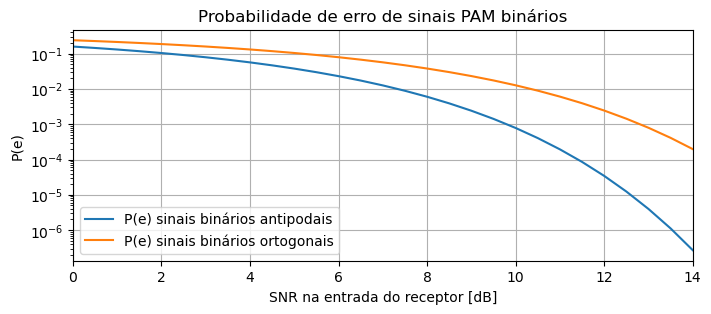

In [31]:
SNRdB = np.arange(0,14.5,0.5)
SNR = 10**(SNRdB/10)

Pe_anti = Q(np.sqrt(SNR))
Pe_orto = Q(np.sqrt(SNR/2))


plt.figure()
plt.semilogy(SNRdB, Pe_anti, '-', label='P(e) sinais binários antipodais')
plt.semilogy(SNRdB, Pe_orto, '-', label='P(e) sinais binários ortogonais')
plt.xlabel('SNR na entrada do receptor [dB]')
plt.ylabel('P(e)')
plt.title('Probabilidade de erro de sinais PAM binários')
plt.xlim(min(SNRdB), max(SNRdB))
plt.legend()
plt.grid();

### Modulações M-PAM

Os símbolos da constelação M-PAM podem ser representados por

$$
\begin{equation}
s_m=\sqrt{E_g} A_m, \quad m=1,2, \ldots, M
\end{equation}
$$
com
$$
\begin{equation}
A_m=(2 m-1-M), \quad m=1,2, \ldots, M
\end{equation}
$$

em que a distância entre símbolos adjacentes é $d=2\sqrt{E_g}$. 

Sabendo que
$$
\sum_{k=1,3,5,...}^n k^2=\frac{n(4n^2-1)}{3},
$$

podemos calcular a energia média por símbolo da constelação como sendo
$$
\begin{align}
E_{a v} & =\frac{1}{M} \sum_{m=1}^M E_m \nonumber \\
& =\frac{E_g}{M} \sum_{m=1}^M(2 m-1-M)^2 \nonumber  \\
& =\frac{E_g}{M} \frac{M\left(M^2-1\right)}{3} \nonumber \\
& =\left(\frac{M^2-1}{3}\right) E_g
\end{align}
$$

Logo, considerando o canal AWGN, o decisor deve tomar uma decisão sobre que símbolo foi transmitido baseado no seguinte sinal $r$:
$$
\begin{equation}
r=s_m+n=\sqrt{E_g} A_m + n
\end{equation}
$$

em que $n$ é uma variável aleatória gaussiana de média nula e variância $\sigma^2 = \frac{N_0}{2}$.

Se todos os símbolos forem equiprováveis, a probabilidade de erro média é dada pela probabilidade de que $n$ exceda a metade da distância entre símbolos adjacentes, para os símbolos internos, somada à probabilidade de erro para os dois símbolos externos. Desse modo,

$$
\begin{align}
P_{e|PAM} & =\frac{M-2}{M} P\left(\left|r-s_m\right|>\sqrt{E_g}\right) + \frac{1}{M} P\left(r-s_1>\sqrt{E_g}\right) + \frac{1}{M} P\left(r-s_M<\sqrt{E_g}\right)\nonumber \\
& =\frac{M-1}{M} P\left(\left|r-s_m\right|>\sqrt{E_g}\right)\nonumber  \\
& =\frac{M-1}{M} \frac{2}{\sqrt{\pi N_0}} \int_{\sqrt{E_g}}^{\infty} e^{-x^2 / N_0} d x \nonumber \\
& =\frac{M-1}{M} \frac{2}{\sqrt{2 \pi}} \int_{\sqrt{2 E_g / N_0}}^{\infty} e^{-x^2 / 2} d x\nonumber  \\
& =\frac{2(M-1)}{M} Q\left(\sqrt{\frac{2 E_g}{N_0}}\right)
\end{align}
$$

Logo, podemos escrever $P_{e|PAM}$ em termos de $E_{a v}$ como

$$
\begin{equation}
P_{e|PAM} =\frac{2(M-1)}{M} Q\left(\sqrt{\frac{6}{(M^2-1)}\frac{E_{av}}{N_0}}\right)
\end{equation}
$$

Em termos da energia média por bit $E_b = \frac{E_{av}}{\log_2M}$, temos

$$
\begin{equation}
P_{e|PAM} =\frac{2(M-1)}{M} Q\left(\sqrt{\frac{6\log_2M}{(M^2-1)}\frac{E_b}{N_0}}\right)
\end{equation}
$$

Em termos da $\mathrm{SNR} = \frac{E_{av}}{\sigma^2} = \frac{2E_{av}}{N_0}$, temos

$$
\begin{equation}
P_{e|PAM} =\frac{2(M-1)}{M} Q\left(\sqrt{\frac{3}{(M^2-1)}\mathrm{SNR}}\right)
\end{equation}
$$

e em termos da razão sinal-ruído por bit $\mathrm{SNR}_b = \frac{\mathrm{SNR}}{\log_2M}$

$$
\begin{equation}
P_{e|PAM} =\frac{2(M-1)}{M} Q\left(\sqrt{\frac{3\log_2M}{(M^2-1)}\mathrm{SNR_b}}\right)
\end{equation}
$$

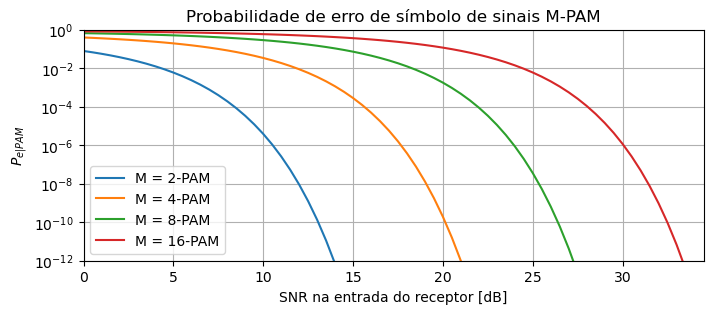

In [32]:
SNRdB = np.arange(0,35,0.5)
SNR = 10**(SNRdB/10)

Pe_anti = Q(np.sqrt(SNR))
Pe_orto = Q(np.sqrt(SNR/2))

Eg = 1

plt.figure()
for M in [2, 4, 8, 16]:
    
    Eav = (M**2-1)/3
    
    Pe = 2*(M-1)/M*Q(np.sqrt((6*SNR)/(M**2-1)))
    
    plt.semilogy(SNRdB, Pe, '-', label=f'M = {M}-PAM')
    
plt.xlabel('SNR na entrada do receptor [dB]')
plt.ylabel('$P_{e|PAM}$')
plt.title('Probabilidade de erro de símbolo de sinais M-PAM')
plt.xlim(min(SNRdB), max(SNRdB))
plt.ylim(1e-12, 1)
plt.legend()
plt.grid();

### Modulações M-PSK

Os símbolos da constelação M-PSK podem ser representados por $\mathbf{s}_m = \sqrt{E_s}e^{j\theta_m} = \sqrt{E_s}(\cos{\theta_m}+j\operatorname{sen}\theta_m)$, em que $\theta_m = (m-1)\frac{2\pi}{M}$, com $m=1,2,\dots, M$ e $E_s$ é a energia de cada símbolo da constelação.

Uma vez que todos os símbolos da constelação possuem a mesma energia. O detector ótimo para esse esquema de modulação no canal AWGN pode ser implementado calculando a métrica de correlação entre o sinal recebido $\mathbf{r} = [r_1, r_2]$ e os símbolos da constelação $\mathbf{s}_m$:

$$
C\left(\mathbf{r}, \mathbf{s}_m\right)=\mathbf{r} \cdot \mathbf{s}_m, \quad m=1,2, \ldots, M.
$$

Este detector é equivalente a um detector de fase que calcula a fase do sinal recebido $\theta_r = \tan^{-1} (r_2/r_1)$ e decide pelo símbolo $\mathbf{s}_m$ cuja fase está mais próxima de $\theta_r$. Para determinar a probabilidade de erro, temos que determinar a fdp de $\theta_r$.

Considere o caso em que a fase do símbolo transmitido é zero $\theta = 0$. Temos, então: $\mathbf{s}_1 =\left[\sqrt{E_s}, 0\right]$. O sinal recebido terá componentes

$$
\begin{align}
& r_1 = \sqrt{E_s} + n_1 \nonumber\\
& r_2 = n_2\nonumber
\end{align}
$$

Considerando que $n_1$ e $n_2$ são duas variáveis aleatórias gaussianas idependentes de média nula e variância $\sigma_n^2$, a distribuição condicional conjunta de $[r_1,r_2]$ é dada por

$$
\begin{equation}\label{gauss_cart}
p(r_1, r_2|\mathbf{s}_1) = \frac{1}{2 \pi \sigma_n^2} \exp \left[- \frac{ \left(r_1-\sqrt{E}_s \right)^2 + r_2^2}{2\sigma_n^2}\right]
\end{equation}
$$

A fdp de $\theta_r$ é obtida passando ($\ref{gauss_cart}$) para coordenadas polares. Seja $v = \sqrt{r_1^2 + r_1^2}$, temos então:

$$
\begin{equation}\label{gauss_polar}
p\left(v, \theta_r|\mathbf{s}_1\right)=\frac{v}{2 \pi \sigma_n^2} \exp \left(-\frac{v^2+E_s-2 \sqrt{E_s}v \cos \theta_r}{2 \sigma_n^2}\right)
\end{equation}
$$

Para obter $p\left(\theta_r|\mathbf{s}_1\right)$, integramos ($\ref{gauss_polar}$) em $v$ no intervalo $0$ a $\infty$, ou seja,

$$
\begin{align}
p\left(\theta_r|\mathbf{s}_1\right) & =\int_0^{\infty}p\left(v, \theta_r|\mathbf{s}_1\right) dv \nonumber\\
& =\frac{1}{2 \pi} e^{-2 \gamma_r \sin ^2 \theta_r} \int_0^{\infty} v e^{-\left(v-\sqrt{4 \gamma_r} \cos \theta_r\right)^2 / 2} d v
\end{align}
$$

em que $\gamma_r = \frac{E_s}{N_0}$. Portanto, dado que $\mathbf{s}_1$ foi transmitido, a detecção correta ocorrerá sempre que  $-\pi/M \leq \theta_r \leq \pi/M$. Logo, a probabilidade de erro será dada por

$$
\begin{equation}\label{prob_err_psk}
P(e|\mathbf{s}_1)=1-\int_{-\pi/M}^{\pi/M} p\left(\theta_r|\mathbf{s}_1\right) d \theta_r
\end{equation}
$$

Na maoria dos casos, não existe nenhuma forma simplificada para a integral em ($\ref{prob_err_psk}$), de modo que esta necessita ser calculada numericamente.

$$
\begin{align}
P_e & \approx 1-\int_{-\pi / M}^{\pi / M} \sqrt{\frac{\frac{2E_s}{N_0}}{\pi}} \cos \theta_r e^{-\frac{2E_s}{N_0} \sin ^2 \theta_r} d \theta_r\nonumber \\
& \approx \frac{2}{\sqrt{2 \pi}} \int_{\sqrt{\frac{2E_s}{N_0}} \sin \frac{\pi}{M}}^{\infty} e^{-u^2 / 2} d u \nonumber \\
& =2 Q\left(\sqrt{\frac{2E_s}{N_0}} \sin \frac{\pi}{M}\right) \nonumber \\
& =2 Q\left(\sqrt{k \frac{2E_b}{N_0}} \sin \frac{\pi}{M}\right)
\end{align}
$$

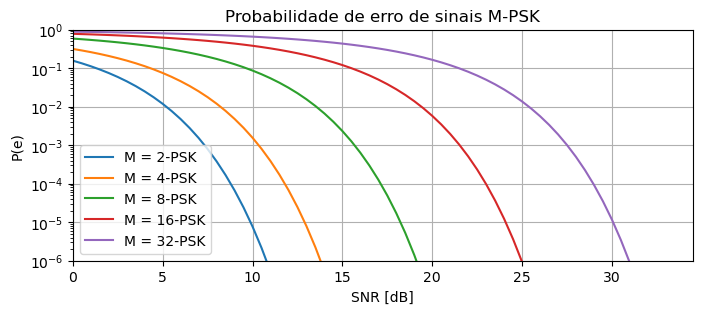

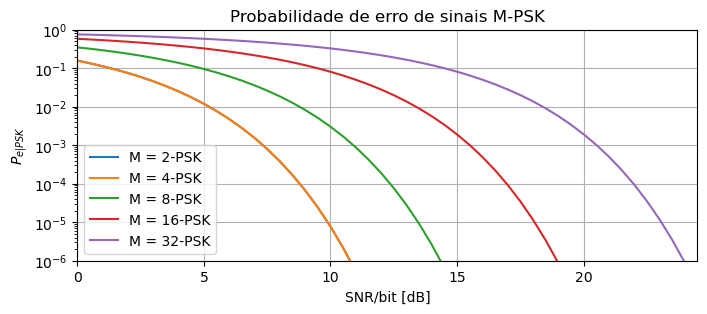

In [33]:
SNRdB = np.arange(0,35,0.5)
SNRb_dB = np.arange(0,25,0.5)
SNR = 10**(SNRdB/10)

Es = 1

plt.figure()
for M in [2, 4, 8, 16, 32]:
        
    Pe = 2*Q(np.sqrt(2*SNR)*np.sin(π/M))
    
    plt.semilogy(SNRdB, Pe, '-', label=f'M = {M}-PSK')
    
plt.xlabel('SNR [dB]')
plt.ylabel('P(e)')
plt.title('Probabilidade de erro de sinais M-PSK')
plt.xlim(min(SNRdB), max(SNRdB))
plt.ylim(1e-6, 1)
plt.legend()
plt.grid();

plt.figure()
for M in [2, 4, 8, 16, 32]:      
    SNRb = 10**(SNRb_dB/10)
    k = np.log2(M)
    
    Pe = 2*Q(np.sqrt(2*k*SNRb)*np.sin(π/M))
    
    plt.semilogy(SNRb_dB, Pe, '-', label=f'M = {M}-PSK')
    
plt.xlabel('SNR/bit [dB]')
plt.ylabel('$P_{e|PSK}$')
plt.title('Probabilidade de erro de sinais M-PSK')
plt.xlim(min(SNRb_dB), max(SNRb_dB))
plt.ylim(1e-6, 1)
plt.legend()
plt.grid();

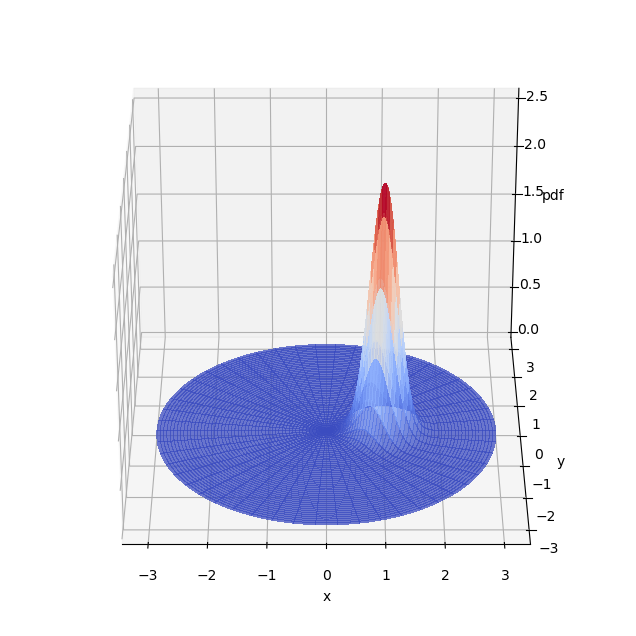

In [34]:
import numpy as np
from scipy.integrate import dblquad, quad
import matplotlib.pyplot as plt
from matplotlib import cm

π = np.pi

def gaussCart(y, x, σ=0.25, Es=1):
    return 1/(2*π*σ**2)*np.exp(-((x-np.sqrt(Es))**2 + y**2)/(2*σ**2))

vGaussCart = np.vectorize(gaussCart)

r = np.linspace(0, 3, 1000)
θ = np.linspace(-π, π, 1000)

r, θ = np.meshgrid(r,θ)
x, y = r*np.cos(θ), r*np.sin(θ)
pos = np.dstack((x, y))

z = vGaussCart(y, x).reshape(1000,1000)

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=1, antialiased=False,alpha=0.75)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('pdf')
ax.view_init(elev=30, azim=270)
plt.show()

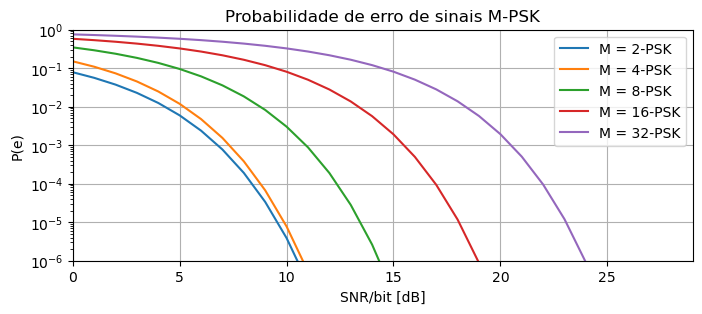

In [35]:
EbN0 = np.arange(0, 30, 1)
Pe = np.zeros(EbN0.shape)

for M in [2, 4, 8, 16, 32]:
    if M == 2:
        Pe = Q(np.sqrt(2*10**(EbN0/10)))
    else:
        Pe = np.zeros(EbN0.shape)    
        for ind, SNRb in enumerate(EbN0): 
            SNR = SNRb + 10*np.log10(np.log2(M))

            SNR_lin = 10**(SNR/10)
            N0 = 1/SNR_lin

            def gaussCart(y, x, N0=N0, Es=1):
                return 1/(π*N0) * np.exp(-( (x - np.sqrt(Es) )**2 + y**2) / N0 )

            def gUp(x):        
                return min(x*np.tan(π/M), 10)

            def gBot(x):        
                return max(-x*np.tan(π/M), -10)

            Pe[ind] = 1 - dblquad(gaussCart, 0, 5, gBot, gUp, epsrel=1.49e-20)[0]

    plt.semilogy(EbN0, Pe,'-', label=f'M = {M}-PSK');

plt.xlabel('SNR/bit [dB]')
plt.ylabel('P(e)')
plt.title('Probabilidade de erro de sinais M-PSK')
plt.xlim(min(EbN0), max(EbN0))
plt.ylim(1e-6, 1)
plt.grid()
plt.legend();

### Modulações M-QAM "quadradas" (*square M-QAM*)

Assuma que em cada intervalo de sinalização $T_s$, o transmissor envia um sinal $s(t)$ dentre os $M$ possíveis de uma modulação M-QAM, i.e. $s_m(t) \in \left\lbrace s_1(t),s_2(t),\dots, s_M(t)\right\rbrace$. Considere que no intervalo de $0\leq t \leq T_s$ o transmissor enviou o sinal $s_m(t)$

$$\begin{align}
s_m(t) &= s_{mI}g(t)\cos(2\pi f_c t)-s_{mQ}g(t)\operatorname{sen}(2\pi f_c t)\nonumber\\
&= \Re\left[(s_{mI}+js_{mQ})g(t)\exp(j2\pi f_c t)\right]\nonumber\\
&= \Re\left[s_mg(t)\exp(j2\pi f_c t)\right]\nonumber
\end{align}
$$

em que $s_m = s_{mI}+js_{mQ}$ corresponde ao símbolo complexo da constelação. 

No caso de constelações M-QAM retangulares em que $M = 2^k$ e o número de bits por símbolo $k$ é par (e.g. $M = 4,16,64,256,\dots$), as componentes $s_{I}$ e $s_{Q}$ podem ser entendidas símbolos de uma constelação $\sqrt{M}$-PAM, ou seja

$$
\begin{equation}
s_{mI}, s_{mQ} \in \left\lbrace A_n | n=1,2, \ldots, \sqrt{M}\right\rbrace
\end{equation}
$$

$$
\begin{equation}
A_n = \sqrt{E_g}(2n-1-\sqrt{M}), \quad n=1,2, \ldots, \sqrt{M}
\end{equation}
$$

em que a distância entre símbolos adjacentes é $d=2\sqrt{E_g}$.

Neste caso, a energia média $E_{av}$ dos símbolos da constelação será dada por

$$
\begin{align}
E_{av} &= \frac{1}{M}\sum_{m=1}^{M}\| s_m\|^2 \nonumber\\
&= \sum_{m=1}^{M} (s_{mI}^2 + s_{mQ}^2)\nonumber\\
&=\frac{2\sqrt{M}E_g}{M} \sum_{m=1}^\sqrt{M} (2m-1-\sqrt{M})^2\nonumber \\
& =\frac{2\sqrt{M}E_g}{M} \frac{\sqrt{M}\left(M-1\right)}{3}\nonumber \\
& =E_g\frac{2\left(M-1\right)}{3}
\end{align}
$$

Um erro de símbolo ocorrerá no receptor se qualquer das componentes $s_{mI}$ e $s_{mQ}$ ultrapassar os respectivos limiares de decisão. Seja $P_{e|QAM}$ a probabilidade média de erro, temos que

$$
\begin{align}
P_{e|QAM} & = 1 - \left(1 - P_{e|PAM}\right)^2 \nonumber \\
& =1 - \left(1-\frac{2(\sqrt{M}-1)}{\sqrt{M}} Q\left(\sqrt{\frac{2 E_g}{N_0}}\right)\right)^2\nonumber\\
& =1 - \left(1-2\left(1 - \frac{1}{\sqrt{M}} \right)Q\left(\sqrt{\frac{2 E_g}{N_0}}\right)\right)^2\nonumber\\
& =1 - \left(1-4\left(1 - \frac{1}{\sqrt{M}} \right)Q\left(\sqrt{\frac{2 E_g}{N_0}}\right) + 4\left(1 - \frac{1}{\sqrt{M}} \right)^2Q^2\left(\sqrt{\frac{2 E_g}{N_0}}\right)\right)\nonumber\nonumber\\
&=4\left(1 - \frac{1}{\sqrt{M}} \right)Q\left(\sqrt{\frac{2 E_g}{N_0}}\right) - 4\left(1 - \frac{1}{\sqrt{M}} \right)^2Q^2\left(\sqrt{\frac{2 E_g}{N_0}}\right)\nonumber\\
&\leq 4\left(1 - \frac{1}{\sqrt{M}} \right)Q\left(\sqrt{\frac{2 E_g}{N_0}}\right) \nonumber\\
&\leq 4\left(1 - \frac{1}{\sqrt{M}} \right)Q\left(\sqrt{\frac{3}{(M-1)}\frac{E_{av}}{N_0}}\right) \\
\end{align}
$$

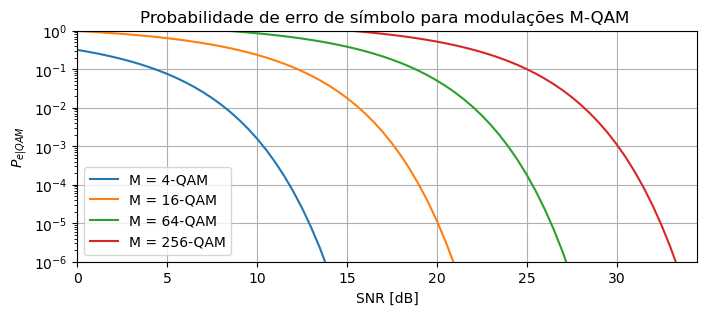

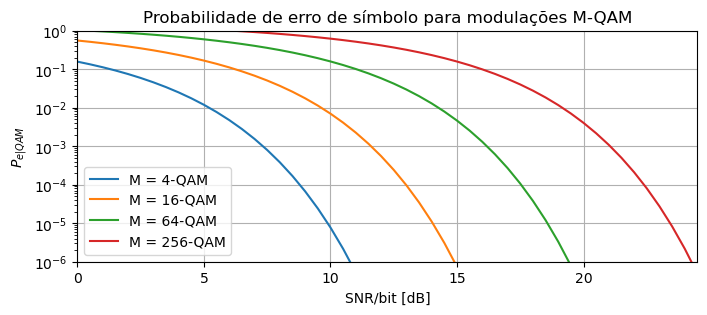

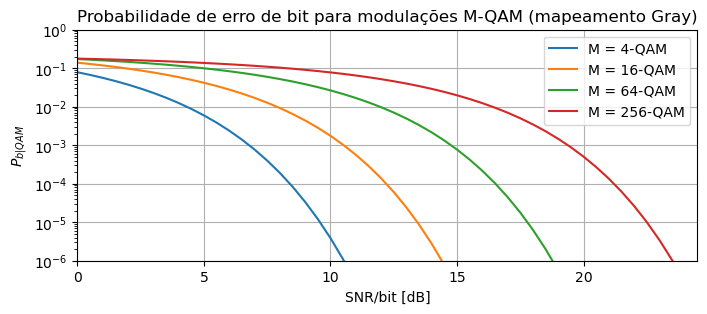

In [36]:
SNRdB = np.arange(0,35,0.5)
SNRb_dB = np.arange(0,25,0.5)
SNR = 10**(SNRdB/10)

Es = 1

plt.figure()
for M in [4, 16, 64, 256]:
        
    Pe = 4*(1-1/np.sqrt(M))*Q(np.sqrt(3/(M-1)*SNR))
    
    plt.semilogy(SNRdB, Pe, '-', label=f'M = {M}-QAM')
    
plt.xlabel('SNR [dB]')
plt.ylabel('$P_{e|QAM}$')
plt.title('Probabilidade de erro de símbolo para modulações M-QAM ')
plt.xlim(min(SNRdB), max(SNRdB))
plt.ylim(1e-6, 1)
plt.legend()
plt.grid();

plt.figure()
for M in [4, 16, 64, 256]:      
    SNRb = 10**(SNRb_dB/10)
    k = np.log2(M)
    
    Pe = 4*(1-1/np.sqrt(M))*Q(np.sqrt(3*k/(M-1)*(SNRb)))
    
    plt.semilogy(SNRb_dB, Pe, '-', label=f'M = {M}-QAM')
    
plt.xlabel('SNR/bit [dB]')
plt.ylabel('$P_{e|QAM}$')
plt.title('Probabilidade de erro de símbolo para modulações M-QAM')
plt.xlim(min(SNRb_dB), max(SNRb_dB))
plt.ylim(1e-6, 1)
plt.legend()
plt.grid();

plt.figure()
for M in [4, 16, 64, 256]:      
    SNRb = 10**(SNRb_dB/10)
    k = np.log2(M)
    
    Pe = 4*(1-1/np.sqrt(M))*Q(np.sqrt(3*k/(M-1)*(SNRb)))/k
    
    plt.semilogy(SNRb_dB, Pe, '-', label=f'M = {M}-QAM')
    
plt.xlabel('SNR/bit [dB]')
plt.ylabel('$P_{b|QAM}$')
plt.title('Probabilidade de erro de bit para modulações M-QAM (mapeamento Gray)')
plt.xlim(min(SNRb_dB), max(SNRb_dB))
plt.ylim(1e-6, 1)
plt.legend()
plt.grid();

##  Limitante da união de probabilidades de erro

Sabemos que para uma constelação binária antipodal $s\in \left\lbrace -\sqrt{E_g}, \sqrt{E_g} \right\rbrace$ a probabilidade de erro é dada por

$$
\begin{equation}\nonumber
P_e^{bin} = Q\left(\sqrt{\frac{2 E_g}{N_0}}\right).
\end{equation}
$$

Considerando que a distância entre os símbolos é $d=2\sqrt{E_g}$, temos $E_g = \frac{d^2}{4}$, de modo que

$$
\begin{equation}\label{Pe_bin}
P_e^{bin} = Q\left(\sqrt{\frac{d^2}{2N_0}}\right).
\end{equation}
$$

ou seja, a probabilidade de erro depende apenas da densidade espectral de potência do ruído e da distância euclideana entre os dois símbolos da constelação.

A partir de ($\ref{Pe_bin}$) é possível obter um *limitante superior* da probabilidade de erro de símbolo para constelações arbitrárias, denominado limitante da união.

Para exemplificar o uso desse limitante, considere o caso da constelação 4-QAM ilustrada na Fig. 7. 

<img src="./figuras/Fig10.png" width="800">
<center>Fig.7: Regiões de decisão binárias para a constelação 4-QAM.</center>

Assumindo $s_1$ como o símbolo transmitido, se calcularmos a probabilidade de erro de símbolo $P_e^{bin}$ para cada um dos demais símbolos da constelação temos

$$
\begin{align}
P_{e_1}^{b i n} &=P\left(\hat{s}=s_2 | s_1\right) = Q\left(\sqrt{\frac{d_1^2}{2N_0}}\right)\\
P_{e_2}^{b i n} &=P\left(\hat{s}=s_3 | s_1\right) = Q\left(\sqrt{\frac{d_1^2}{2N_0}}\right)\\
P_{e_3}^{b i n} &=P\left(\hat{s}=s_4 | s_1\right) = Q\left(\sqrt{\frac{d_2^2}{2N_0}}\right)\\
\end{align}
$$

<img src="./figuras/Fig11.png" width="600">
<center>Fig.8: (a) Sobreposição das regiões de decisão binárias para a constelação 4-QAM. (b) Regiões de decisão para a constelação 4-QAM.</center>

Perceba que a probabilidade de erro exata $P_{e|4-QAM}$ da constelação 4-QAM é dada pela integral da fdp $p(r_1, r_2|s_1)$ em todas as regiões de decisão associadas aos símbolos $s_m\neq s_1$. Desse modo, um limitante superior para o valor dessa integral é dado pelo somatório das integrais utilizadas na determinação de $P_e^{bin}$, ou seja

$$
\begin{align}
P_{e|4-QAM} &\leq P_{e_1}^{b i n} + P_{e_2}^{b i n} + P_{e_3}^{b i n}\nonumber\\
 &= Q\left(\sqrt{\frac{d_1^2}{2N_0}}\right) + Q\left(\sqrt{\frac{d_1^2}{2N_0}}\right) + Q\left(\sqrt{\frac{d_2^2}{2N_0}}\right)\nonumber\\
 &= 2Q\left(\sqrt{\frac{d_1^2}{2N_0}}\right) + Q\left(\sqrt{\frac{d_2^2}{2N_0}}\right)\nonumber\\
 &= 2Q\left(\sqrt{\frac{2E_g}{N_0}}\right) + Q\left(\sqrt{\frac{4E_g}{N_0}}\right)\label{limUni_4QAM}
\end{align}
$$

Para valores típicos de $\mathrm{SNR}$ em sistemas de comunicações, o segundo termo em ($\ref{limUni_4QAM}$) tende a ser muito menor do que o primeiro. Dessa forma, podemos constatar que a probabilidade de erro é dominada pela probabilidade de erro para os símbolos na vizinhança mais próxima do símbolo $s_1$. Se compararmos ($\ref{limUni_4QAM}$) com a probabilidade de erro exata $P_{e|4-QAM}=2 Q\left(\sqrt{\frac{2 E_g}{N_0}}\right)-Q^2\left(\sqrt{\frac{2 E_g}{N_0}}\right)$, vemos que os mesmos termos dominantes aparecem nas duas expressões.


De modo geral, podemos escrever:

$$
\begin{equation}
P_{e}=\sum_{i=1}^M P(\hat{s} \neq s_i| s_i) P(s_i) = \frac{1}{M} \sum_{i=1}^M P(\hat{s} \neq s_i| s_i)
\end{equation}
$$

em que a segunda igualdade é válida no caso de símbolos equiprováveis e 
$$
\begin{align}
P(\hat{s} \neq s_i| s_i) & \leq \sum_{k \neq i} P_e^{bin}(\hat{s} = s_k| s_i) \\
& =\sum_{k \neq i} Q\left(\frac{\left\|s_k-s_i\right\|}{\sqrt{2 N_0}}\right)
\end{align}
$$

ou seja,

$$
\begin{equation}
P_{e}\leq \frac{1}{M} \sum_{i=1}^M \sum_{k \neq i} Q\left(\frac{\left\|s_k-s_i\right\|}{\sqrt{2 N_0}}\right)
\end{equation}
$$

Finalmente, podemos considerar apenas os termos dominantes fazendo
$$
\begin{equation}
P_e \leq \frac{2 K}{M} Q\left(\frac{d_{\min }}{\sqrt{2 N_0}}\right)
\end{equation}
$$

em que $K$ é o número de pares de símbolos que encontram-se separados pela distância mínima $d_{min}$.

**Exemplo**: aplicação do limitante da união para constelações M-QAM.

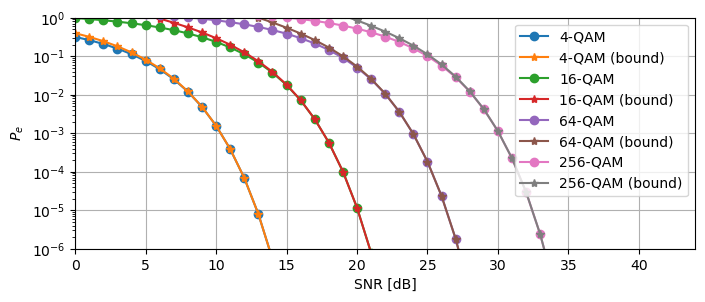

In [37]:
def Pe_squareQAM(M, SNR):
    return 4*(1-1/np.sqrt(M))*Q(np.sqrt(3/(M-1)*SNR))


def Pe_bin(d, N0):
    return Q(d/np.sqrt(2*N0))


def uniBound_Pe(const, N0):
    # Calculate the union bound of error probabilities
    
    ind = np.arange(const.size)    
    pair = np.transpose([np.tile(ind, len(ind)), np.repeat(ind, len(ind))])
    
    Pe_bound = 0
    for k in range(len(pair)):
        if pair[k,0] != pair[k,1]:
            dist = np.abs(const[pair[k,0]]-const[pair[k,1]]) # calculate the distance between pair of symbols
            Pe_bound += Pe_bin(dist, N0) # accumulate the binary Pe between the pair of symbols
    
    return Pe_bound/M

# plot Pe and union bound as a function of SNR for several different QAM orders
for M in [4, 16, 64, 256]:
    constSymb = grayMapping(M, 'qam')   # Gray constellation mapping
    
    SNR_val = np.arange(0,35,1)
    Pe_uniBound = np.zeros(SNR_val.shape)
    Pe = np.zeros(SNR_val.shape)
        
    for k, SNR in enumerate(SNR_val):
        N0 = 1/(10**(SNR/10))
        
        Pe_uniBound[k] = uniBound_Pe(pnorm(constSymb), N0)
        Pe[k] = Pe_squareQAM(M, 10**(SNR/10))
    
    plt.semilogy(SNR_val, Pe, '-o', label=f'{M}-QAM')
    plt.semilogy(SNR_val, Pe_uniBound, '-*',label=f'{M}-QAM (bound)')
    
plt.xlabel('SNR [dB]')
plt.ylabel('$P_{e}$')
plt.xlim(min(SNR_val), max(SNR_val+10))
plt.ylim(1e-6, 1)
plt.legend()
plt.grid();

## Referências

[1] J. G. Proakis, M. Salehi, Communication Systems Engineering, 2nd Edition, Pearson, 2002.